# Bogota Accessibility: Impact of the TransMiCable Gondola

### Brian Hill, Logan Ritter, Manuel Santana

The goal of this notebook will be to calculate preliminary accessibility estimates for Bogota using the simplified data on employment by Logan Ritter, and the GTFS file by Jarvis Yuan.  

The assumption is that before running this notebook the otp system as outlined in Bogota_OTP_Setup, including the appropriate GTFS, OSM, and Graph objects, as well as Jython, Pandas, Numpy, OSMNX.

### Overview
#### [Section 1: OTP Travel Times & Employment](#section_1)
* [Establish Run Specifications](#run_spec)
* [Make Hexagons](#make_hexagons)
* [Distribute Employment](#distribute_employment)
* [OTP: Aquire Travel Times](#otp_travel_times)

#### [Section 2: Accessibility Analysis](#section_2)
* [Calculate Accessibility](#calculate_acessibility)
* [Data Visualizations](#data_vis)
* [Conclusion](#conclusion)


In [6]:
# Import libraries
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import shutil
import glob
import time
import threading
import os
import tobler
# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import seaborn as sns
import shapely 
from shapely.geometry import Polygon
import mapclassify 
import pysal
import contextily as ctx
# Suppresss warnings 
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Set path to jython file 
# e.g. /Users/BrianHill/jython2.7.2/bin/jython
jython_path = '/Users/BrianHill/jython2.7.2/bin/jython'

# Set path to otp folder
# Ensure ends in a '/'
# e.g. /Users/BrianHill/otp/
otp_path = '/Users/BrianHill/otp/'

# Change notebook directory to otp_path
os.chdir(otp_path)

# Section 1: OTP Travel Times & Employment

## Establish Run Specifications <a class="anchor" id="run_spec"></a>
The goal is to enable easy customization of input parameters, as well as the ability to store each run's results in a separate folder.

In [65]:
# Location to find city-specific data (e.g. jobs, administrative boundaries)
city_data = r'bogota_data/'

# Location to store run-specific data
run_folder_name = r'bogota_otp_g1'
# We now make this directory
!mkdir {run_folder_name}

# Prefix to add to files from this run 
run_prefix = 'otp_g1_'

# Together
run_path = run_folder_name + '/' + run_prefix
run_path

'bogota_otp_g1/otp_g1_'

In [67]:
# Hexagon size 
hexagon_diameter = 5000

# Set departure time for travel time calculations
# Format 'year, month, day, hour, minute, second'  (e.g. '2019, 4, 4, 6, 00, 00')
departure_time = '2019, 04, 02, 06, m, 00'

# Set departure minute array to choose from 
departure_minutes = [0]

In [19]:
%%bash

cd graphs/bogota_no_gondola
# Router configuration details 
cat > router-config.json
{
  "routingDefaults": {
    "walkSpeed": 1.4,
    "waitReluctance": 1,
    "waitAtBeginningFactor": 1,
    "walkReluctance": 1,
    "stairsReluctance": 1
  }
}


In [6]:
%%bash
# Copy router configuration to gondola router
cp graphs/bogota_no_gondola/router-config.json graphs/bogota_gondola/router-config.json


## Make Hexagons <a class="anchor" id="make_hexagons"></a>

In this step we cover the city with hexagons of the preset size.

In [7]:

# Get the Bogota city boundaires 
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
#bogota_boundary.plot()

# Import ability to draw distances from geodesic (precise)
from geopy.distance import geodesic
#geodesic(origin, dest).km*1000 returns length in meters 

# How large is the city?
xmin, ymin, xmax, ymax = bogota_boundary.total_bounds
# geodesic((latitude,longitude), (latitude, longitude))
dist_long = geodesic((ymin,xmin), (ymin,xmax)).km*1000
print("Longitudinal distance:", dist_long)
dist_lat = geodesic((ymin,xmin), (ymax,xmin)).km*1000
print("Latitudinal distance:", dist_lat)

# Diameter of hexagons 
d = hexagon_diameter

# Horizontal width of hexagon
w = np.sin(np.deg2rad(60))*d

# Approximate size of hexagon grid 
n_cols = int(dist_long/w) +1
print("Approx. number of columns: ", n_cols)
n_rows = int(dist_lat/(3/4 * d)) + 10
print("Approx. number of rows:", n_rows)

# Overlay with equally spaced hexagons

from matplotlib.patches import RegularPolygon

# ax = bogota_boundary.boundary.plot(edgecolor='black',figsize=(20,60))
w = (xmax-xmin)/n_cols # width of hexagon
d = w/np.sin(np.pi/3) #diameter of hexagon
array_of_hexes = []
for rows in range(0,n_rows):
    hcoord = np.arange(xmin,xmax,w) + (rows%2)*w/2
    vcoord = [ymax- rows*d*0.75]*n_cols
    for x, y in zip(hcoord, vcoord):#, colors):
        hexes = RegularPolygon((x, y), numVertices=6, radius=d/2, alpha=0.2, edgecolor='k')
        verts = hexes.get_path().vertices
        trans = hexes.get_patch_transform()
        points = trans.transform(verts)
        array_of_hexes.append(Polygon(points))
        # ax.add_patch(hexes)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#plt.show()

# Extract hexagons inside of the boundary 

hex_grid = gpd.GeoDataFrame({'geometry':array_of_hexes},crs={'init':'epsg:4326'})
bogota_hex = gpd.overlay(hex_grid,bogota_boundary)
bogota_hex = gpd.GeoDataFrame(bogota_hex,geometry='geometry')
#bogota_hex.boundary.plot()

# Strip off unnecesary fields 
bogota_hex.reset_index(inplace=True)
bogota_hex.rename(columns={'index':'HEXID'},inplace=True)
bogota_hex = bogota_hex[['HEXID','geometry']]


Longitudinal distance: 23668.826877335207
Latitudinal distance: 40029.88097027054
Approx. number of columns:  6
Approx. number of rows: 20


## Distribute Employment <a class="anchor" id="distribute_employment"></a>

Using the jobs data from the 2019 Bogota household travel survey, we calculate the number of trips ending in each TAZ, and then, use tobler to distribute the jobs into each hexagon.  The jobs are distributed proportional to the area of the TAZ in the hexagon.  

In [8]:
# Load the survey data file and calculate number of work destinations in each TAZ
viajes = pd.read_csv(city_data + ("viajes.csv"), sep=';')
ZAT = gpd.read_file((city_data + "ZONAS/ZAT.shp"), sep=';')
viajes_clean = viajes[["id_hogar", "id_persona", "id_viaje", "p17_Id_motivo_viaje", "zat_origen", "zat_destino", "f_exp"]]
#counting the number of trips (either work related or all trips) in each TAZ
#origin is a boolean about whether we want to look at the origin or destination of the trips
#mintrips is used to filter out TAZ's that have a low number of trips to better zoom into the data
def location_counts(origin, only_jobs, min_trips, no_table=False):
    if origin:
        zat_column = "zat_origen"
    else:
        zat_column = "zat_destino"
    if only_jobs:
        viajes_new = viajes[viajes["p17_Id_motivo_viaje"] == 1]
    else:
        viajes_new = viajes
    counts = viajes_new.groupby(zat_column).sum()
    counts.reset_index(level = 0, inplace = True)
    counts["jobs_count"] = counts["f_exp"]
    counts = counts[[zat_column, "jobs_count"]]
    counts = pd.merge(counts, ZAT[["Area", "ZAT", "geometry"]], left_on = zat_column, right_on = "ZAT")
    counts = gpd.GeoDataFrame(counts, geometry=counts["geometry"])
    counts = counts[[zat_column, "jobs_count", "geometry"]]
    counts = counts[counts["jobs_count"] > min_trips]
    if no_table:
        return
    return counts
work_destination_job_count_TAZ = location_counts(False, True, 0)
work_destination_job_count_TAZ

,zat_destino,jobs_count,geometry
0,1.0,308.737618,"POLYGON Z ((-74.06383 4.77235 0.00000, -74.063..."
1,2.0,107.002656,"POLYGON Z ((-74.05306 4.82550 0.00000, -74.053..."
2,3.0,311.561784,"POLYGON Z ((-74.03007 4.82343 0.00000, -74.029..."
3,4.0,700.972891,"POLYGON Z ((-74.04066 4.78609 0.00000, -74.040..."
4,7.0,1622.454159,"POLYGON Z ((-74.04154 4.77941 0.00000, -74.040..."
...,...,...,...
1013,1903.0,2650.408680,"POLYGON Z ((-73.95672 4.94255 0.00000, -73.955..."
1014,1904.0,92.772562,"POLYGON Z ((-73.86543 5.00181 0.00000, -73.847..."
1015,1905.0,4437.804867,"POLYGON Z ((-73.94001 4.93084 0.00000, -73.940..."
1016,1906.0,587.320839,"POLYGON Z ((-73.98746 5.04507 0.00000, -73.986..."


In [9]:
bogota_hex

,HEXID,geometry
0,0,"POLYGON ((-74.06502 4.82207, -74.07879 4.81412..."
1,1,"POLYGON ((-74.02802 4.82333, -74.02802 4.82291..."
2,2,"MULTIPOLYGON (((-74.05793 4.81966, -74.04579 4..."
3,3,"POLYGON ((-74.02802 4.82291, -74.02635 4.82194..."
4,4,"POLYGON ((-74.09911 4.76138, -74.09911 4.76134..."
5,5,"MULTIPOLYGON (((-74.06356 4.77131, -74.06356 4..."
6,6,"POLYGON ((-74.04579 4.79213, -74.02802 4.78187..."
7,7,"POLYGON ((-74.12207 4.75408, -74.11688 4.75108..."
8,8,"POLYGON ((-74.09911 4.76134, -74.08134 4.75108..."
9,9,"POLYGON ((-74.06356 4.76134, -74.04579 4.75108..."


In [24]:
# Ensure both dataframes have same CRS
work_destination_job_count_TAZ.crs = {'init':'epsg:4686'}
bogota_hex.crs = {'init':"epsg:4686"}
# TOBLER: Weight hexagon job counts by weighted average of TAZ job counts
bogota_hex_jobs = tobler.area_weighted.area_interpolate(source_df=work_destination_job_count_TAZ, target_df=bogota_hex, extensive_variables=["jobs_count"])
bogota_hex_jobs.reset_index(inplace=True)
bogota_hex_jobs.rename(columns={'index':'HEXID'},inplace=True)
bogota_hex_jobs.to_file((run_path + 'bogota_hex_jobs.shp'))
bogota_hex_jobs


,HEXID,jobs_count,geometry
0,0,303.151783,"POLYGON ((-74.06502 4.82207, -74.07879 4.81412..."
1,1,12094.873185,"POLYGON ((-74.02802 4.82333, -74.02802 4.82291..."
2,2,2660.098268,"MULTIPOLYGON (((-74.05793 4.81966, -74.04579 4..."
3,3,5162.137447,"POLYGON ((-74.02802 4.82291, -74.02635 4.82194..."
4,4,10044.188415,"POLYGON ((-74.09911 4.76138, -74.09911 4.76134..."
5,5,5198.575816,"MULTIPOLYGON (((-74.06356 4.77131, -74.06356 4..."
6,6,31184.228590,"POLYGON ((-74.04579 4.79213, -74.02802 4.78187..."
7,7,21752.499842,"POLYGON ((-74.12207 4.75408, -74.11688 4.75108..."
8,8,57534.440258,"POLYGON ((-74.09911 4.76134, -74.08134 4.75108..."
9,9,49048.631772,"POLYGON ((-74.06356 4.76134, -74.04579 4.75108..."


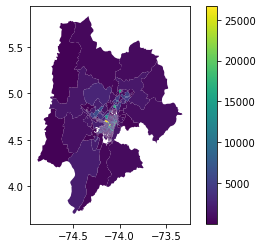

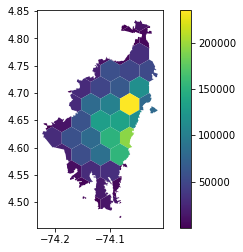

In [25]:
# Rough plot of trip endings by TAZ
work_destination_job_count_TAZ.plot(column='jobs_count', legend=True)
# Rough plot of jobs distribution by hexagon
bogota_hex_jobs.plot(column='jobs_count', legend=True)

## OTP: Aquire Travel Times <a class="anchor" id="otp_travel_time"></a>

A great thanks to Rafael Pereria for providing the base code for this section in his 

We will be running analysis on the overall accessibility with and without the gondola for all of bogota using the hexagons.  

Also here we consider changing the python script to make it more managable to do calculations on them, to calculate the accessibility mid-way through instead of at the end.  Also, the code has been properly threaded and currently saves multiple csvs instead of just one big one to avoid memory errors.

Further, for speed improvements the code has been parallized.


In [13]:
bogota_hex_jobs

,HEXID,jobs_count,geometry
0,0,23.921741,"POLYGON ((-74.08050 4.83566, -74.08134 4.83517..."
1,1,171.510487,"POLYGON ((-74.07670 4.83682, -74.07670 4.83606..."
2,2,226.797366,"POLYGON ((-74.07361 4.83631, -74.07361 4.83606..."
3,3,37.826245,"POLYGON ((-74.07274 4.83556, -74.07361 4.83606..."
4,4,23.705130,"POLYGON ((-74.06539 4.83546, -74.06588 4.83517..."
...,...,...,...
4579,4579,38.228012,"POLYGON ((-74.07927 4.47412, -74.07979 4.47382..."
4580,4580,2.694928,"POLYGON ((-74.08288 4.47310, -74.08288 4.47265..."
4581,4581,220.973221,"POLYGON ((-74.08065 4.47431, -74.07979 4.47382..."
4582,4582,52.662294,"POLYGON ((-74.07958 4.47191, -74.07979 4.47203..."


In [81]:
# PICK UP HERE:
bogota_hex_jobs = gpd.read_file('bogota_data/hex400_2020_07_30_bogota_hex_jobs.shp')


In [69]:

# Add in longitude and latitude of the centroid of each hexagon to prepare for Open Trip Planner Processing
bogota_hex_point_jobs = gpd.GeoDataFrame(bogota_hex_jobs)
bogota_hex_point_jobs['centroid'] = bogota_hex_point_jobs.centroid
bogota_hex_point_jobs.set_geometry('centroid', inplace=True)
bogota_hex_point_jobs['longitude'] = bogota_hex_point_jobs.geometry.x
bogota_hex_point_jobs['latitude'] = bogota_hex_point_jobs.geometry.y

# Save as simple csv to be accessed by processing script later
bogota_hex_point_jobs[['HEXID','longitude','latitude']].to_csv((run_path + 'bogota_hex_jobs.csv'))

bogota_hex_point_jobs

,HEXID,jobs_count,geometry,centroid,longitude,latitude
0,0,23.921741,"POLYGON ((-74.08050 4.83566, -74.08134 4.83517...",POINT (-74.08111 4.83538),-74.081111,4.835380
1,1,171.510487,"POLYGON ((-74.07670 4.83682, -74.07670 4.83606...",POINT (-74.07794 4.83599),-74.077945,4.835990
2,2,226.797366,"POLYGON ((-74.07361 4.83631, -74.07361 4.83606...",POINT (-74.07526 4.83620),-74.075259,4.836202
3,3,37.826245,"POLYGON ((-74.07274 4.83556, -74.07361 4.83606...",POINT (-74.07330 4.83598),-74.073303,4.835981
4,4,23.705130,"POLYGON ((-74.06539 4.83546, -74.06588 4.83517...",POINT (-74.06581 4.83537),-74.065809,4.835366
...,...,...,...,...,...,...
4579,4579,38.228012,"POLYGON ((-74.07927 4.47412, -74.07979 4.47382...",POINT (-74.07987 4.47446),-74.079869,4.474459
4580,4580,2.694928,"POLYGON ((-74.08288 4.47310, -74.08288 4.47265...",POINT (-74.08297 4.47290),-74.082975,4.472896
4581,4581,220.973221,"POLYGON ((-74.08065 4.47431, -74.07979 4.47382...",POINT (-74.08107 4.47279),-74.081065,4.472792
4582,4582,52.662294,"POLYGON ((-74.07958 4.47191, -74.07979 4.47203...",POINT (-74.07940 4.47308),-74.079399,4.473085


#### Create Script

Here we use the %%bash command to use terminal to write the travel time calculating script.  Note that we have included the customizable run_path variable in two ways.  First, we passed it into the first line using 's- {run_path}' then refrencing it as ${1}.  Second, we used set to, somewhat less elegantly, 'replace to_be_filled_run_path' with our run_path variable. 

We also replace 'to_be_filled_departure_time' with our departure_time variable. 

In [70]:
%%bash -s {run_path}
cat > "${1}parallel_no_gondola.py"

import time
import threading
import shutil
import glob

# Various Input files and settings
router = 'bogota_no_gondola'
my_run_path = 'to_be_filled_run_path'
my_otp_path = 'to_be_filled_otp_path'
points_file = my_run_path + 'bogota_hex_jobs.csv'
dest_file = points_file
departure_minutes = to_be_filled_departure_minutes
departure_time = 'to_be_filled_departure_time'

max_threads = 4
# SOURCE: RAFAEL PERERIA, python_script
from org.opentripplanner.scripting.api import OtpsEntryPoint
# Instantiate an OtpsEntryPoint
# NOTE WOULD NEED TO CHANGE THIS IN ORDER TO 
otp = OtpsEntryPoint.fromArgs(['--graphs', '/Users/BrianHill/otp/graphs',
                               '--router', router])

# Start timing the code
start_time = time.time()

# Get the default router
router = otp.getRouter(router)
                               
for m in departure_minutes:
    minute = str(m).zfill(2)
    #exact_departure_time = r'to_be_filled_departure_time' % minute 
    #set different output file for each time
    output_file = my_run_path + minute + '_parallel_no_gondola.csv'
    # Create a default request for a given departure time
    req = otp.createRequest()
    req.setDateTime(to_be_filled_departure_time)  # set departure time
    req.setModes('WALK,BUS,RAIL,TRANSIT')         # define transport mode
    req.setClampInitialWait(0)

    points = otp.loadCSVPopulation(points_file, 'latitude', 'longitude')
    dests = otp.loadCSVPopulation(dest_file, 'latitude', 'longitude')
    
    def do_the_stuff(h,i, origin, req):
        # Create a CSV output
        matrixCsv = otp.createCSVOutput()
        #matrixCsv.setHeader([ 'year','depart_time', 'origin', 'destination', 'walk_distance', 'travel_time' ])
        #print("Processing origin: ", str(h)+"-"+str(0)," ", origin.getStringData('GEOID'), 'on ',threading.current_thread())
        req.setOrigin(origin)
        spt = router.plan(req)
        if spt is None: return
        # Evaluate the SPT for all points
        result = spt.eval(dests)
        # Add a new row of result in the CSV output
        for r in result:
           matrixCsv.addRow([ origin.getStringData('HEXID'), r.getIndividual().getStringData('HEXID'), r.getWalkDistance() , r.getTime(),  r.getBoardings() ])
        # Save the result
        csv_name = my_run_path + 'zarb_unique_' + minute + 'no_gondola_origin' + str(origin.getStringData('HEXID')) + '.csv'
        matrixCsv.save(csv_name)
        print(csv_name)
        print("Time since start was %g seconds" % (time.time() - start_time))
    
    
    # start looping over jobs
    i = 1
    origins = []
    for origin in points:
        origins.append(origin)
    while i < len(origins) + 1:
        if threading.active_count() < max_threads + 1:
            origin = origins[i - 1]
            thread = threading.Thread(target=do_the_stuff,args=(6,i, origin, req))
            thread.start()
            #thread.daemon = True        
            i += 1
        else:
            time.sleep(0.1)
    # now wait for all daemon threads to end before letting
    # the main thread die. Otherwise stuff will get cut off
    # before it's finished
    while threading.active_count() > 1:
        time.sleep(0.1)
    print('ALL JOBS COMPLETED! Concatenating files')
    
    
    #import csv files from folder
    path = my_otp_path + my_run_path
    allFiles = glob.glob(path + 'zarb_unique_' + minute + 'no_gondola_origin*.csv')
    allFiles.sort()  # glob lacks reliable ordering, so impose your own if output order matters
    with open(output_file, 'wb') as outfile:
        for i, fname in enumerate(allFiles):
            with open(fname, 'rb') as infile:
                if True:
                    infile.readline()  # Read all lines
                # Block copy rest of file from input to output without parsing
                shutil.copyfileobj(infile, outfile)
                print(fname + " has been imported.")

    print("Done with minute %s" % minute)
                
print("Elapsed time was %g seconds" % (time.time() - start_time))

In [71]:
# Fill in departure time with stored departure_time variable
!sed -i '' "s#to_be_filled_departure_time#{departure_time}#" {run_path}parallel_no_gondola.py
# Fill in to_be_filled_minutes with stored run_path variable 
!sed -i '' "s#to_be_filled_departure_minutes#{departure_minutes}#" {run_path}parallel_no_gondola.py
# Fill in to_be_filled_run_path with stored run_path variable 
!sed -i '' "s#to_be_filled_run_path#{run_path}#" {run_path}parallel_no_gondola.py
# Fill in to_be_filled_otp_path with otp path
!sed -i '' "s#to_be_filled_otp_path#{otp_path}#" {run_path}parallel_no_gondola.py

We also make the gondola script by replacing every instance of no_gondola with gondola, thus refrencing the gondola router instead of the no_gondola router, and saving file names appropriately.

In [72]:
# Make gondola script
!sed 's/no_gondola/gondola/' {run_path}parallel_no_gondola.py > {run_path}parallel_gondola.py


### Run Travel Time Calculations

#### No Gondola

In [73]:
# Run the python script on the java OTP jar using jython
!{jython_path} -J-XX:-UseGCOverheadLimit -J-Xmx10G -Dpython.path=otp-1.4.0-shaded.jar {run_path}parallel_no_gondola.py
!say done processing no gondola nodes


01:12:09.575 INFO (OTPServer.java:39) Wiring up and configuring server.
01:12:09.651 INFO (GraphScanner.java:64) Attempting to automatically register routerIds [bogota_no_gondola]
01:12:09.652 INFO (GraphScanner.java:65) Graph files will be sought in paths relative to /Users/BrianHill/otp/graphs
01:12:09.657 INFO (GraphService.java:176) Registering new router 'bogota_no_gondola'
01:12:09.658 INFO (InputStreamGraphSource.java:181) Loading graph...
01:12:10.309 INFO (Graph.java:746) Graph version: MavenVersion(1, 4, 0, , b272f14007c97d769216e9ebab65baad7410cdf5)
01:12:10.310 INFO (Graph.java:747) OTP version:   MavenVersion(1, 4, 0, , b272f14007c97d769216e9ebab65baad7410cdf5)
01:12:10.310 INFO (Graph.java:764) This graph was built with the currently running version and commit of OTP.
01:12:23.094 INFO (Graph.java:731) Main graph read. |V|=292682 |E|=1404186
hsqldb.db.HSQLDB4AD417742A.ENGINE INFO dataFileCache open start
01:12:27.736 INFO (GraphIndex.java:127) Indexing graph...
01:12:29.7

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin52.csv
Time since start was 460.198 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin54.csv
Time since start was 460.212 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin53.csv
Time since start was 460.224 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin55.csv
Time since start was 461.663 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin56.csv
Time since start was 501.955 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin59.csv
Time since start was 501.989 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin57.csv
Time since start was 502.394 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin58.csv
Time since start was 502.524 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin61.csv
Time since start was 521.915 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin60.csv
Time since start was 521.929 seconds
01:21:15.783 ERROR (Graph.java:238) dupl

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin136.csv
Time since start was 915.271 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin137.csv
Time since start was 915.394 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin141.csv
Time since start was 915.487 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin138.csv
Time since start was 917.523 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin139.csv
Time since start was 921.79 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin142.csv
Time since start was 930.203 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin143.csv
Time since start was 932.22 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin140.csv
Time since start was 932.43 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin144.csv
Time since start was 935.748 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin145.csv
Time since start was 943.97 seconds
bogota_otp_g1/otp_g1_zarb_unique_0

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin224.csv
Time since start was 1220.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin225.csv
Time since start was 1227.59 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin227.csv
Time since start was 1229.14 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin226.csv
Time since start was 1232.52 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin228.csv
Time since start was 1235.38 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin230.csv
Time since start was 1243.86 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin229.csv
Time since start was 1244.57 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin231.csv
Time since start was 1245.99 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin232.csv
Time since start was 1252.53 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin233.csv
Time since start was 1258.94 seconds
bogota_otp_g1/otp_g1_zarb_uniqu

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin310.csv
Time since start was 1559.93 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin313.csv
Time since start was 1565.85 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin311.csv
Time since start was 1566.54 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin312.csv
Time since start was 1567.51 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin314.csv
Time since start was 1573.03 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin316.csv
Time since start was 1578.25 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin317.csv
Time since start was 1578.95 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin318.csv
Time since start was 1579.66 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin319.csv
Time since start was 1585.29 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin320.csv
Time since start was 1590.37 seconds
bogota_otp_g1/otp_g1_zarb_uniq

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin397.csv
Time since start was 1886.84 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin400.csv
Time since start was 1890.01 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin401.csv
Time since start was 1896.85 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin402.csv
Time since start was 1899.35 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin403.csv
Time since start was 1900.01 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin404.csv
Time since start was 1903.57 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin405.csv
Time since start was 1910.23 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin406.csv
Time since start was 1912.69 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin407.csv
Time since start was 1913.54 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin408.csv
Time since start was 1917.75 seconds
bogota_otp_g1/otp_g1_zarb_uniq

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin486.csv
Time since start was 2237.82 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin488.csv
Time since start was 2249.59 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin489.csv
Time since start was 2252.03 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin487.csv
Time since start was 2253.28 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin490.csv
Time since start was 2254.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin491.csv
Time since start was 2263.81 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin492.csv
Time since start was 2265.78 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin493.csv
Time since start was 2267.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin494.csv
Time since start was 2267.87 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin495.csv
Time since start was 2277.62 seconds
bogota_otp_g1/otp_g1_zarb_unique

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin576.csv
Time since start was 2604.77 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin577.csv
Time since start was 2611.56 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin580.csv
Time since start was 2615.22 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin578.csv
Time since start was 2622.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin579.csv
Time since start was 2623.15 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin581.csv
Time since start was 2624.58 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin582.csv
Time since start was 2629.62 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin583.csv
Time since start was 2634.72 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin584.csv
Time since start was 2635.36 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin585.csv
Time since start was 2636.62 seconds
bogota_otp_g1/otp_g1_zarb_uniqu

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin661.csv
Time since start was 2950.22 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin662.csv
Time since start was 2950.61 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin663.csv
Time since start was 2953.85 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin664.csv
Time since start was 2957.78 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin666.csv
Time since start was 2965.56 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin667.csv
Time since start was 2967.25 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin665.csv
Time since start was 2970.23 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin668.csv
Time since start was 2972.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin669.csv
Time since start was 2984.12 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin672.csv
Time since start was 2986.96 seconds
bogota_otp_g1/otp_g1_zarb_uniqu

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin746.csv
Time since start was 3310.74 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin747.csv
Time since start was 3311.54 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin748.csv
Time since start was 3312.63 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin749.csv
Time since start was 3318.36 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin750.csv
Time since start was 3327.66 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin751.csv
Time since start was 3328.72 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin752.csv
Time since start was 3329.95 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin753.csv
Time since start was 3336.21 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin756.csv
Time since start was 3344.75 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin754.csv
Time since start was 3345.33 seconds
bogota_otp_g1/otp_g1_zarb_uniq

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin827.csv
Time since start was 3643.31 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin831.csv
Time since start was 3654.97 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin833.csv
Time since start was 3655.47 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin830.csv
Time since start was 3656.96 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin832.csv
Time since start was 3659.31 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin834.csv
Time since start was 3669.38 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin835.csv
Time since start was 3670.16 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin836.csv
Time since start was 3671.95 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin837.csv
Time since start was 3676.86 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin839.csv
Time since start was 3686.89 seconds
bogota_otp_g1/otp_g1_zarb_uniq

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin913.csv
Time since start was 4013.44 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin915.csv
Time since start was 4015.22 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin916.csv
Time since start was 4025.89 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin917.csv
Time since start was 4028.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin919.csv
Time since start was 4040.56 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin918.csv
Time since start was 4041.54 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin921.csv
Time since start was 4051.24 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin920.csv
Time since start was 4051.73 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin922.csv
Time since start was 4054.76 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin923.csv
Time since start was 4058.42 seconds
bogota_otp_g1/otp_g1_zarb_uniqu

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin999.csv
Time since start was 4376.01 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1000.csv
Time since start was 4383.61 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1001.csv
Time since start was 4386.65 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1002.csv
Time since start was 4389.24 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1003.csv
Time since start was 4390.19 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1004.csv
Time since start was 4395.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1005.csv
Time since start was 4400.39 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1006.csv
Time since start was 4400.91 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1007.csv
Time since start was 4405.31 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1008.csv
Time since start was 4412.32 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1083.csv
Time since start was 4756.28 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1084.csv
Time since start was 4759.77 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1086.csv
Time since start was 4761.89 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1085.csv
Time since start was 4762.71 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1087.csv
Time since start was 4770.15 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1088.csv
Time since start was 4778.02 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1089.csv
Time since start was 4780.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1091.csv
Time since start was 4787.68 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1090.csv
Time since start was 4789.76 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1092.csv
Time since start was 4800.9 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1168.csv
Time since start was 16024 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1169.csv
Time since start was 23215.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1171.csv
Time since start was 23220.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1170.csv
Time since start was 23220.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1172.csv
Time since start was 23233.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1173.csv
Time since start was 23234.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1175.csv
Time since start was 23253.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1174.csv
Time since start was 23257.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1176.csv
Time since start was 23262.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1177.csv
Time since start was 23263.1 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1254.csv
Time since start was 37570.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1259.csv
Time since start was 37584 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1261.csv
Time since start was 37594.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1262.csv
Time since start was 37596.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1260.csv
Time since start was 37604 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1263.csv
Time since start was 37615.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1266.csv
Time since start was 37636.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1265.csv
Time since start was 37637 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1264.csv
Time since start was 37654 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1267.csv
Time since start was 37657.7 seconds
bogota_otp_g1/otp_g1_zarb_un

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1344.csv
Time since start was 38886.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1345.csv
Time since start was 38902.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1346.csv
Time since start was 38904 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1347.csv
Time since start was 38924.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1352.csv
Time since start was 38946 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1350.csv
Time since start was 38957.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1351.csv
Time since start was 38960.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1353.csv
Time since start was 38968.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1354.csv
Time since start was 39006.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1357.csv
Time since start was 39019.7 seconds
bogota_otp_g1/otp_g1_zar

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1431.csv
Time since start was 40086.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1432.csv
Time since start was 40086.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1433.csv
Time since start was 40132 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1434.csv
Time since start was 40154.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1442.csv
Time since start was 40158.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1441.csv
Time since start was 40184.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1443.csv
Time since start was 40203.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1444.csv
Time since start was 40236.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1445.csv
Time since start was 40243.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1446.csv
Time since start was 40245.5 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1525.csv
Time since start was 41052.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1526.csv
Time since start was 41069.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1528.csv
Time since start was 41082.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1527.csv
Time since start was 41085.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1529.csv
Time since start was 41087.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1530.csv
Time since start was 41126.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1531.csv
Time since start was 41148 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1532.csv
Time since start was 41151.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1533.csv
Time since start was 41152.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1535.csv
Time since start was 41185.4 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1617.csv
Time since start was 41720.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1618.csv
Time since start was 41724.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1619.csv
Time since start was 41726.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1620.csv
Time since start was 41755.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1621.csv
Time since start was 41760.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1622.csv
Time since start was 41763.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1623.csv
Time since start was 41774.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1625.csv
Time since start was 41798.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1624.csv
Time since start was 41800.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1626.csv
Time since start was 41801.5 seconds
bogota_otp_g1/otp_g1

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1701.csv
Time since start was 42369.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1703.csv
Time since start was 42370.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1702.csv
Time since start was 42371.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1704.csv
Time since start was 42383.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1706.csv
Time since start was 42390.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1705.csv
Time since start was 42394.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1707.csv
Time since start was 42395.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1708.csv
Time since start was 42403.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1709.csv
Time since start was 42413.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1710.csv
Time since start was 42415.3 seconds
bogota_otp_g1/otp_g1

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1785.csv
Time since start was 42781.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1787.csv
Time since start was 42783.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1786.csv
Time since start was 42783.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1788.csv
Time since start was 42786.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1789.csv
Time since start was 42795.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1791.csv
Time since start was 42797.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1790.csv
Time since start was 42798 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1792.csv
Time since start was 42802.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1793.csv
Time since start was 42812.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1794.csv
Time since start was 42814.1 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1869.csv
Time since start was 43178.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1870.csv
Time since start was 43178.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1871.csv
Time since start was 43189 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1872.csv
Time since start was 43191.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1873.csv
Time since start was 43192.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1874.csv
Time since start was 43200.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1875.csv
Time since start was 43204.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1876.csv
Time since start was 43206.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1877.csv
Time since start was 43208.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1878.csv
Time since start was 43213.5 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1953.csv
Time since start was 43551.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1954.csv
Time since start was 43554.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1955.csv
Time since start was 43555.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1956.csv
Time since start was 43568.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1957.csv
Time since start was 43571.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1958.csv
Time since start was 43574.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1959.csv
Time since start was 43579.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1960.csv
Time since start was 43588.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1961.csv
Time since start was 43591.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1962.csv
Time since start was 43595.5 seconds
bogota_otp_g1/otp_g1

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2038.csv
Time since start was 43900.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2037.csv
Time since start was 43903.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2039.csv
Time since start was 43911.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2040.csv
Time since start was 43915.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2041.csv
Time since start was 43920.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2042.csv
Time since start was 43925.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2043.csv
Time since start was 43933.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2044.csv
Time since start was 43936.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2045.csv
Time since start was 43942.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2046.csv
Time since start was 43942.9 seconds
bogota_otp_g1/otp_g1

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2121.csv
Time since start was 44247.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2122.csv
Time since start was 44253.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2123.csv
Time since start was 44254.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2124.csv
Time since start was 44259.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2125.csv
Time since start was 44264.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2126.csv
Time since start was 44270 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2127.csv
Time since start was 44273.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2128.csv
Time since start was 44278.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2129.csv
Time since start was 44282.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2130.csv
Time since start was 44290.7 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2205.csv
Time since start was 44591 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2206.csv
Time since start was 44591.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2207.csv
Time since start was 44594.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2208.csv
Time since start was 44603 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2209.csv
Time since start was 44604.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2210.csv
Time since start was 44606.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2211.csv
Time since start was 44607.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2212.csv
Time since start was 44616.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2214.csv
Time since start was 44619.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2213.csv
Time since start was 44622.2 seconds
bogota_otp_g1/otp_g1_zar

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2288.csv
Time since start was 44935.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2289.csv
Time since start was 44936.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2290.csv
Time since start was 44937.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2291.csv
Time since start was 44944.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2292.csv
Time since start was 44949.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2293.csv
Time since start was 44951 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2294.csv
Time since start was 44951.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2295.csv
Time since start was 44956.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2296.csv
Time since start was 44962.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2297.csv
Time since start was 44966.4 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2372.csv
Time since start was 45273 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2373.csv
Time since start was 45273.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2374.csv
Time since start was 45275.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2375.csv
Time since start was 45277 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2377.csv
Time since start was 45288 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2378.csv
Time since start was 45288.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2376.csv
Time since start was 45288.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2379.csv
Time since start was 45290.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2380.csv
Time since start was 45303 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2383.csv
Time since start was 45303.4 seconds
bogota_otp_g1/otp_g1_zarb_un

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2456.csv
Time since start was 45619.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2457.csv
Time since start was 45622.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2458.csv
Time since start was 45626.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2459.csv
Time since start was 45633.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2460.csv
Time since start was 45635.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2461.csv
Time since start was 45639.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2462.csv
Time since start was 45642.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2463.csv
Time since start was 45649.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2464.csv
Time since start was 45652.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2465.csv
Time since start was 45654.9 seconds
bogota_otp_g1/otp_g1

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2540.csv
Time since start was 45974.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2541.csv
Time since start was 45977.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2542.csv
Time since start was 45979 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2543.csv
Time since start was 45982.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2544.csv
Time since start was 45988.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2545.csv
Time since start was 45992.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2546.csv
Time since start was 45996.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2547.csv
Time since start was 46002.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2548.csv
Time since start was 46006.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2549.csv
Time since start was 46008.8 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2624.csv
Time since start was 46348 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2626.csv
Time since start was 46354.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2625.csv
Time since start was 46357.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2627.csv
Time since start was 46357.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2628.csv
Time since start was 46365.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2629.csv
Time since start was 46370.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2631.csv
Time since start was 46371.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2630.csv
Time since start was 46372.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2632.csv
Time since start was 46383.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2633.csv
Time since start was 46384.9 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2708.csv
Time since start was 46678.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2709.csv
Time since start was 46685.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2711.csv
Time since start was 46687.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2710.csv
Time since start was 46687.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2712.csv
Time since start was 46697.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2713.csv
Time since start was 46704 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2714.csv
Time since start was 46708 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2715.csv
Time since start was 46708.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2716.csv
Time since start was 46716.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2717.csv
Time since start was 46724.1 seconds
bogota_otp_g1/otp_g1_zar

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2792.csv
Time since start was 47034.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2794.csv
Time since start was 47043.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2793.csv
Time since start was 47044.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2795.csv
Time since start was 47047 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2796.csv
Time since start was 47048.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2798.csv
Time since start was 47059.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2797.csv
Time since start was 47059.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2800.csv
Time since start was 47062.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2799.csv
Time since start was 47069.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2801.csv
Time since start was 47073.9 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2875.csv
Time since start was 47386.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2877.csv
Time since start was 47394.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2878.csv
Time since start was 47396.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2879.csv
Time since start was 47402.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2880.csv
Time since start was 47403.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2881.csv
Time since start was 47413.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2882.csv
Time since start was 47416.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2883.csv
Time since start was 47418 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2884.csv
Time since start was 47418.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2885.csv
Time since start was 47429.2 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2962.csv
Time since start was 47736.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2960.csv
Time since start was 47738.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2961.csv
Time since start was 47738.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2963.csv
Time since start was 47749.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2965.csv
Time since start was 47753.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2966.csv
Time since start was 47753.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2964.csv
Time since start was 47760.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2967.csv
Time since start was 47764.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2968.csv
Time since start was 47771.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2969.csv
Time since start was 47771.9 seconds
bogota_otp_g1/otp_g1

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3044.csv
Time since start was 48086 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3045.csv
Time since start was 48089.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3046.csv
Time since start was 48089.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3047.csv
Time since start was 48097.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3048.csv
Time since start was 48102.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3050.csv
Time since start was 48103.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3049.csv
Time since start was 48105.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3051.csv
Time since start was 48112.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3052.csv
Time since start was 48120.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3053.csv
Time since start was 48121.7 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3128.csv
Time since start was 48438.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3129.csv
Time since start was 48443.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3130.csv
Time since start was 48448.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3131.csv
Time since start was 48448.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3132.csv
Time since start was 48452.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3133.csv
Time since start was 48458.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3134.csv
Time since start was 48463.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3135.csv
Time since start was 48463.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3136.csv
Time since start was 48471.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3137.csv
Time since start was 48475.8 seconds
bogota_otp_g1/otp_g1

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3210.csv
Time since start was 48791.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3209.csv
Time since start was 48791.3 seconds
14:45:45.151 ERROR (Graph.java:238) duplicate vertex label in graph (added vertex to graph anyway): <sample-3159 lat,lng=4.614789352256455,-74.10142698550708>
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3211.csv
Time since start was 48793.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3212.csv
Time since start was 48794.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3213.csv
Time since start was 48806.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3214.csv
Time since start was 48807.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3215.csv
Time since start was 48808.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3216.csv
Time since start was 48810.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3217.

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3292.csv
Time since start was 49130.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3293.csv
Time since start was 49134.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3294.csv
Time since start was 49141.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3296.csv
Time since start was 49147.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3295.csv
Time since start was 49150.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3297.csv
Time since start was 49153.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3298.csv
Time since start was 49157.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3299.csv
Time since start was 49166.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3300.csv
Time since start was 49168 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3301.csv
Time since start was 49171.4 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3376.csv
Time since start was 49495.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3377.csv
Time since start was 49498.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3378.csv
Time since start was 49503.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3379.csv
Time since start was 49507.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3380.csv
Time since start was 49510.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3381.csv
Time since start was 49514 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3382.csv
Time since start was 49522 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3383.csv
Time since start was 49523.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3384.csv
Time since start was 49526.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3385.csv
Time since start was 49531.2 seconds
bogota_otp_g1/otp_g1_zar

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3459.csv
Time since start was 49844.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3460.csv
Time since start was 49844.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3464.csv
Time since start was 49859.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3462.csv
Time since start was 49859.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3465.csv
Time since start was 49860.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3463.csv
Time since start was 49862.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3467.csv
Time since start was 49874.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3466.csv
Time since start was 49875.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3468.csv
Time since start was 49875.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3469.csv
Time since start was 49878.1 seconds
bogota_otp_g1/otp_g1

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3544.csv
Time since start was 50207 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3545.csv
Time since start was 50211.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3546.csv
Time since start was 50215.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3547.csv
Time since start was 50222.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3548.csv
Time since start was 50222.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3549.csv
Time since start was 50226.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3550.csv
Time since start was 50231.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3552.csv
Time since start was 50237.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3551.csv
Time since start was 50240.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3553.csv
Time since start was 50241.9 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3628.csv
Time since start was 50557.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3629.csv
Time since start was 50562 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3630.csv
Time since start was 50567.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3631.csv
Time since start was 50570.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3632.csv
Time since start was 50573.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3633.csv
Time since start was 50577.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3634.csv
Time since start was 50583.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3635.csv
Time since start was 50584.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3636.csv
Time since start was 50587.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3637.csv
Time since start was 50591.4 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3712.csv
Time since start was 50911.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3715.csv
Time since start was 50917.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3714.csv
Time since start was 50917.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3713.csv
Time since start was 50918.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3716.csv
Time since start was 50923.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3717.csv
Time since start was 50930.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3719.csv
Time since start was 50932.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3718.csv
Time since start was 50933 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3720.csv
Time since start was 50939 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3721.csv
Time since start was 50946.4 seconds
bogota_otp_g1/otp_g1_zar

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3796.csv
Time since start was 51263.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3798.csv
Time since start was 51263.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3797.csv
Time since start was 51264.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3799.csv
Time since start was 51273.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3800.csv
Time since start was 51280.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3802.csv
Time since start was 51288.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3801.csv
Time since start was 51289.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3803.csv
Time since start was 51298.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3804.csv
Time since start was 51305.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3805.csv
Time since start was 51312.7 seconds
bogota_otp_g1/otp_g1

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3880.csv
Time since start was 51634.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3881.csv
Time since start was 51637.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3882.csv
Time since start was 51642.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3883.csv
Time since start was 51648.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3884.csv
Time since start was 51651.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3885.csv
Time since start was 51652.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3886.csv
Time since start was 51658.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3887.csv
Time since start was 51663 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3889.csv
Time since start was 51665.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3888.csv
Time since start was 51666.7 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3964.csv
Time since start was 51972.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3965.csv
Time since start was 51982.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3967.csv
Time since start was 51985.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3966.csv
Time since start was 51985.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3968.csv
Time since start was 51989.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3969.csv
Time since start was 51997.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3971.csv
Time since start was 51998.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3970.csv
Time since start was 51999.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3972.csv
Time since start was 52002 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3973.csv
Time since start was 52013.1 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4047.csv
Time since start was 52308.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4049.csv
Time since start was 52310.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4050.csv
Time since start was 52323.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4051.csv
Time since start was 52323.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4052.csv
Time since start was 52326.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4053.csv
Time since start was 52332.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4055.csv
Time since start was 52341.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4054.csv
Time since start was 52346.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4056.csv
Time since start was 52348 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4057.csv
Time since start was 52350.6 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4133.csv
Time since start was 52660.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4135.csv
Time since start was 52663.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4134.csv
Time since start was 52663.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4136.csv
Time since start was 52671.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4137.csv
Time since start was 52676.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4139.csv
Time since start was 52678.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4138.csv
Time since start was 52681.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4140.csv
Time since start was 52686.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4141.csv
Time since start was 52693.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4143.csv
Time since start was 52697.4 seconds
bogota_otp_g1/otp_g1

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4217.csv
Time since start was 52991.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4219.csv
Time since start was 52997.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4218.csv
Time since start was 52997.5 seconds
15:55:51.314 ERROR (Graph.java:238) duplicate vertex label in graph (added vertex to graph anyway): <sample-4166 lat,lng=4.5451947927223335,-74.08597297101429>
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4220.csv
Time since start was 53004.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4221.csv
Time since start was 53006.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4223.csv
Time since start was 53012 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4222.csv
Time since start was 53012 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4224.csv
Time since start was 53018.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4225.csv

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4303.csv
Time since start was 53305 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4302.csv
Time since start was 53310.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4304.csv
Time since start was 53317.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4305.csv
Time since start was 53318.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4306.csv
Time since start was 53319.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4307.csv
Time since start was 53323.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4308.csv
Time since start was 53330.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4310.csv
Time since start was 53334.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4309.csv
Time since start was 53337.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4311.csv
Time since start was 53338.2 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4386.csv
Time since start was 53638.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4387.csv
Time since start was 53638.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4388.csv
Time since start was 53646.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4389.csv
Time since start was 53651.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4390.csv
Time since start was 53653.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4391.csv
Time since start was 53654.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4392.csv
Time since start was 53663 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4393.csv
Time since start was 53666.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4394.csv
Time since start was 53669.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4395.csv
Time since start was 53670.2 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4470.csv
Time since start was 53967.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4471.csv
Time since start was 53971.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4472.csv
Time since start was 53976.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4473.csv
Time since start was 53977.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4474.csv
Time since start was 53983.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4475.csv
Time since start was 53985 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4476.csv
Time since start was 53990.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4477.csv
Time since start was 53993.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4478.csv
Time since start was 53997.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4479.csv
Time since start was 53998.1 seconds
bogota_otp_g1/otp_g1_z

bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4554.csv
Time since start was 54296.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4555.csv
Time since start was 54299.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4556.csv
Time since start was 54301.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4557.csv
Time since start was 54307.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4558.csv
Time since start was 54310.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4559.csv
Time since start was 54314.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4560.csv
Time since start was 54318.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4561.csv
Time since start was 54322.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4562.csv
Time since start was 54325.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4563.csv
Time since start was 54329.6 seconds
bogota_otp_g1/otp_g1

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1045.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1046.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1047.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1048.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1049.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin105.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1050.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1051.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1052.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1053.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1130.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1131.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1132.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1133.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1134.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1135.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1136.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1137.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1138.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1139.csv has been 

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1205.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1206.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1207.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1208.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1209.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin121.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1210.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1214.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1215.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1216.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1287.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1288.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1289.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin129.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1290.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1291.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1292.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1293.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1294.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1295.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1364.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1365.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1366.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1367.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1368.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1369.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin137.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1370.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1371.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1372.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin145.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1450.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1451.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1452.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1453.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1454.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1455.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1456.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1457.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1458.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1532.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1533.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1535.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1536.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1537.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin154.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1543.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1544.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1545.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1546.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1619.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin162.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1620.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1621.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1622.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1623.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1624.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1625.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1626.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1627.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1696.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1697.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1698.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1699.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin17.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin170.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1700.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1701.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1702.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1703.csv has been imp

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin177.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1770.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1771.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1772.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1773.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1774.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1775.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1776.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1777.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1778.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1849.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin185.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1850.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1851.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1852.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1853.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1854.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1855.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1856.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1857.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1932.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1933.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1934.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1935.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1936.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1937.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1938.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1939.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin194.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin1940.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin201.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2010.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2011.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2012.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2013.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2014.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2015.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2016.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2017.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2018.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin209.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2090.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2091.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2092.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2093.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2094.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2095.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2096.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2097.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2098.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2168.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2169.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin217.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2170.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2171.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2172.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2173.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2174.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2175.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2176.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2241.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2242.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2243.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2244.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2245.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2246.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2247.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2248.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2249.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin225.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2318.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2319.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin232.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2320.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2321.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2322.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2323.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2324.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2325.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2326.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2393.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2394.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2395.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2396.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2397.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2398.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2399.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin24.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin240.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2400.csv has been imp

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2469.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin247.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2470.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2471.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2472.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2473.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2474.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2475.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2476.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2477.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2542.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2543.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2544.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2545.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2546.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2547.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2548.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2549.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin255.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2550.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2619.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin262.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2620.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2621.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2622.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2623.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2624.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2625.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2626.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2627.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2695.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2696.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2697.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2698.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2699.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin27.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin270.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2700.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2701.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2702.csv has been imp

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin277.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2770.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2771.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2772.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2773.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2774.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2775.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2776.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2777.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2778.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2848.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2849.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin285.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2850.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2851.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2852.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2853.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2854.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2855.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2856.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2922.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2923.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2924.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2925.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2926.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2927.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2928.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2929.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin293.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin2930.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin300.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3000.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3001.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3002.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3003.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3004.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3005.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3006.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3007.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3008.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3074.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3075.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3076.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3077.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3078.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3079.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin308.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3080.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3081.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3082.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3152.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3153.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3154.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3155.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3156.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3157.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3158.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3159.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin316.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3160.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3227.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3228.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3229.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin323.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3230.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3231.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3232.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3233.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3234.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3235.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3303.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3304.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3305.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3306.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3307.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3308.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3309.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin331.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3310.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3311.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3382.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3383.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3384.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3385.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3386.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3387.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3388.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3389.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin339.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3390.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3456.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3457.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3458.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3459.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin346.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3460.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3461.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3462.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3463.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3464.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3535.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3536.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3537.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3538.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3539.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin354.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3540.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3541.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3542.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3543.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3613.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3614.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3615.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3616.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3617.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3618.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3619.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin362.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3620.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3621.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3693.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3694.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3695.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3696.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3697.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3698.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3699.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin37.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin370.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3700.csv has been imp

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3769.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin377.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3770.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3771.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3772.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3773.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3774.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3775.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3776.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3777.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3847.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3848.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3849.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin385.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3850.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3851.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3852.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3853.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3854.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3855.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3922.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3923.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3924.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3925.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3926.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3927.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3928.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3929.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin393.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin3930.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4003.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4004.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4005.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4006.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4007.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4008.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4009.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin401.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4010.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4011.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4079.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin408.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4080.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4081.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4082.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4083.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4084.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4085.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4086.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4087.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4157.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4158.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4159.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin416.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4160.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4161.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4162.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4163.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4164.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4165.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4235.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4236.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4237.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4238.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4239.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin424.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4240.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4241.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4242.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4243.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin432.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4320.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4321.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4322.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4323.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4324.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4325.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4326.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4327.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4328.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4395.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4396.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4397.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4398.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4399.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin44.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin440.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4400.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4401.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4402.csv has been imp

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4473.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4474.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4475.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4476.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4477.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4478.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4479.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin448.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4480.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4481.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4551.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4552.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4553.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4554.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4555.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4556.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4557.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4558.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin4559.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin456.csv has been i

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin501.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin502.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin503.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin504.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin505.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin506.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin507.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin508.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin509.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin51.csv has been imported.
/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin586.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin587.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin588.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin589.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin59.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin590.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin591.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin592.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin593.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin594.csv has been imported.
/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin660.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin661.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin662.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin663.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin664.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin665.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin666.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin667.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin668.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin669.csv has been imported.


/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin743.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin744.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin745.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin746.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin747.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin748.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin749.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin75.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin750.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin751.csv has been imported.
/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin822.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin823.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin824.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin825.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin826.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin827.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin828.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin829.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin83.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin830.csv has been imported.
/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin897.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin898.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin899.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin9.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin90.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin900.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin901.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin902.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin903.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin904.csv has been imported.
/Us

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin978.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin979.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin98.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin980.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin981.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin982.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin983.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin984.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin985.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00no_gondola_origin986.csv has been imported.
/

In [74]:
# Remove all of the intermediary files
!rm {run_path}*zarb_unique*

/bin/bash: /bin/rm: Argument list too long


#### Gondola

In [75]:
# Repeat for gondola scenario
!{jython_path} -J-XX:-UseGCOverheadLimit -J-Xmx10G -Dpython.path=otp-1.4.0-shaded.jar {run_path}parallel_gondola.py
!say done processing gondola nodes


16:20:00.156 INFO (OTPServer.java:39) Wiring up and configuring server.
16:20:00.210 INFO (GraphScanner.java:64) Attempting to automatically register routerIds [bogota_gondola]
16:20:00.210 INFO (GraphScanner.java:65) Graph files will be sought in paths relative to /Users/BrianHill/otp/graphs
16:20:00.213 INFO (GraphService.java:176) Registering new router 'bogota_gondola'
16:20:00.215 INFO (InputStreamGraphSource.java:181) Loading graph...
16:20:00.672 INFO (Graph.java:746) Graph version: MavenVersion(1, 4, 0, , b272f14007c97d769216e9ebab65baad7410cdf5)
16:20:00.672 INFO (Graph.java:747) OTP version:   MavenVersion(1, 4, 0, , b272f14007c97d769216e9ebab65baad7410cdf5)
16:20:00.673 INFO (Graph.java:764) This graph was built with the currently running version and commit of OTP.
16:20:11.965 INFO (Graph.java:731) Main graph read. |V|=295688 |E|=1410840
hsqldb.db.HSQLDB4AD417742A.ENGINE INFO dataFileCache open start
16:20:16.727 INFO (GraphIndex.java:127) Indexing graph...
16:20:18.796 INF

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin59.csv
Time since start was 233.275 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin61.csv
Time since start was 236.698 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin60.csv
Time since start was 240.189 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin62.csv
Time since start was 244.374 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin64.csv
Time since start was 254.889 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin65.csv
Time since start was 255 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin66.csv
Time since start was 260.262 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin63.csv
Time since start was 264.879 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin68.csv
Time since start was 270.578 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin67.csv
Time since start was 270.582 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin70.csv
Time since start w

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin147.csv
Time since start was 572.776 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin148.csv
Time since start was 579.893 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin149.csv
Time since start was 584.403 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin150.csv
Time since start was 584.982 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin151.csv
Time since start was 589.479 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin152.csv
Time since start was 594.281 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin153.csv
Time since start was 598.752 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin154.csv
Time since start was 601.203 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin155.csv
Time since start was 604.178 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin156.csv
Time since start was 609.081 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin157.csv
Tim

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin239.csv
Time since start was 913.458 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin240.csv
Time since start was 917.807 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin241.csv
Time since start was 925.908 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin237.csv
Time since start was 925.935 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin242.csv
Time since start was 932.431 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin243.csv
Time since start was 932.806 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin245.csv
Time since start was 938.79 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin246.csv
Time since start was 945.608 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin247.csv
Time since start was 947.526 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin244.csv
Time since start was 948.641 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin248.csv
Time

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin325.csv
Time since start was 1254.37 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin326.csv
Time since start was 1256.35 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin327.csv
Time since start was 1257.67 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin328.csv
Time since start was 1261.89 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin329.csv
Time since start was 1269.76 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin331.csv
Time since start was 1275.95 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin330.csv
Time since start was 1278.46 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin332.csv
Time since start was 1279.31 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin333.csv
Time since start was 1287.16 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin334.csv
Time since start was 1291.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin335.csv
Time

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin415.csv
Time since start was 1617.67 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin416.csv
Time since start was 1617.91 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin417.csv
Time since start was 1626.89 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin418.csv
Time since start was 1631.19 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin419.csv
Time since start was 1636.65 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin420.csv
Time since start was 1637.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin421.csv
Time since start was 1646.33 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin422.csv
Time since start was 1652.75 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin423.csv
Time since start was 1653.19 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin424.csv
Time since start was 1656.03 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin425.csv
Time

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin505.csv
Time since start was 1988.52 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin506.csv
Time since start was 1993.35 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin507.csv
Time since start was 2001.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin508.csv
Time since start was 2005.96 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin510.csv
Time since start was 2011.26 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin511.csv
Time since start was 2020.84 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin512.csv
Time since start was 2022.01 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin509.csv
Time since start was 2026.52 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin513.csv
Time since start was 2030.34 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin515.csv
Time since start was 2042.72 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin516.csv
Time

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin598.csv
Time since start was 2369.01 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin599.csv
Time since start was 2374.73 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin601.csv
Time since start was 2379.81 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin600.csv
Time since start was 2380.38 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin602.csv
Time since start was 2388.39 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin603.csv
Time since start was 2392.11 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin604.csv
Time since start was 2399.14 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin605.csv
Time since start was 2400.91 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin606.csv
Time since start was 2404.93 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin607.csv
Time since start was 2410.77 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin608.csv
Tim

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin686.csv
Time since start was 2736.54 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin687.csv
Time since start was 2742.48 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin688.csv
Time since start was 2744.06 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin689.csv
Time since start was 2748.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin690.csv
Time since start was 2754.96 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin691.csv
Time since start was 2759.81 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin692.csv
Time since start was 2760.56 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin693.csv
Time since start was 2767.28 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin694.csv
Time since start was 2772.16 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin695.csv
Time since start was 2779.18 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin696.csv
Time

Time since start was 3108.55 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin772.csv
Time since start was 3108.59 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin774.csv
Time since start was 3111.07 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin773.csv
Time since start was 3115.37 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin776.csv
Time since start was 3124.94 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin775.csv
Time since start was 3127.98 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin777.csv
Time since start was 3128.66 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin778.csv
Time since start was 3133.09 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin780.csv
Time since start was 3145.64 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin781.csv
Time since start was 3148.55 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin779.csv
Time since start was 3148.6 seconds
bogota_otp_g1/otp_g1_zar

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin859.csv
Time since start was 3491.74 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin860.csv
Time since start was 3499.68 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin861.csv
Time since start was 3501.59 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin862.csv
Time since start was 3505.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin863.csv
Time since start was 3510.64 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin864.csv
Time since start was 3515.94 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin865.csv
Time since start was 3523.63 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin866.csv
Time since start was 3524.23 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin867.csv
Time since start was 3524.86 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin868.csv
Time since start was 3530.99 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin871.csv
Time

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin945.csv
Time since start was 3881.51 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin947.csv
Time since start was 3883.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin948.csv
Time since start was 3889.38 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin946.csv
Time since start was 3889.68 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin949.csv
Time since start was 3898.84 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin950.csv
Time since start was 3903.62 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin952.csv
Time since start was 3906.09 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin951.csv
Time since start was 3906.74 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin953.csv
Time since start was 3917.77 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin954.csv
Time since start was 3923.65 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin955.csv
Time

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1032.csv
Time since start was 4287.78 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1034.csv
Time since start was 4291.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1031.csv
Time since start was 4292.06 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1035.csv
Time since start was 4305.99 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1036.csv
Time since start was 4306.04 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1038.csv
Time since start was 4306.57 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1037.csv
Time since start was 4308.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1040.csv
Time since start was 4317.31 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1042.csv
Time since start was 4320.22 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1041.csv
Time since start was 4321.24 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin103

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1119.csv
Time since start was 4675.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1121.csv
Time since start was 4682.01 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1120.csv
Time since start was 4682.58 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1122.csv
Time since start was 4690.79 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1123.csv
Time since start was 4694.39 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1125.csv
Time since start was 4699.78 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1124.csv
Time since start was 4700.04 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1126.csv
Time since start was 4707.85 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1127.csv
Time since start was 4709.38 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1128.csv
Time since start was 4717.37 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin11

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1208.csv
Time since start was 5077.78 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1207.csv
Time since start was 5080.31 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1209.csv
Time since start was 5084.18 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1210.csv
Time since start was 5097.12 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1214.csv
Time since start was 5099.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1215.csv
Time since start was 5100.15 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1216.csv
Time since start was 5101.41 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1217.csv
Time since start was 5113.93 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1218.csv
Time since start was 5114.89 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1220.csv
Time since start was 5116.32 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin12

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1299.csv
Time since start was 5487.03 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1300.csv
Time since start was 5492.07 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1301.csv
Time since start was 5500.19 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1304.csv
Time since start was 5502.45 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1305.csv
Time since start was 5505.88 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1306.csv
Time since start was 5508.17 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1307.csv
Time since start was 5518.53 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1308.csv
Time since start was 5523.54 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1309.csv
Time since start was 5531.86 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1310.csv
Time since start was 5533.37 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1

Time since start was 5899.64 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1389.csv
Time since start was 5903.34 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1391.csv
Time since start was 5913.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1392.csv
Time since start was 5918.39 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1394.csv
Time since start was 5921.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1395.csv
Time since start was 5922.41 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1396.csv
Time since start was 5933.22 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1397.csv
Time since start was 5933.67 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1398.csv
Time since start was 5938.57 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1399.csv
Time since start was 5938.63 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1400.csv
Time since start was 5953.87 seconds
bogota_otp_g1/o

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1482.csv
Time since start was 6339.15 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1481.csv
Time since start was 6342.79 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1483.csv
Time since start was 6347.92 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1484.csv
Time since start was 6353.42 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1485.csv
Time since start was 6355.74 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1490.csv
Time since start was 6362.68 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1491.csv
Time since start was 6367.51 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1492.csv
Time since start was 6372.84 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1493.csv
Time since start was 6377.78 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1494.csv
Time since start was 6390.41 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1578.csv
Time since start was 6773.03 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1581.csv
Time since start was 6779.83 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1579.csv
Time since start was 6780.66 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1580.csv
Time since start was 6784.46 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1582.csv
Time since start was 6786.68 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1583.csv
Time since start was 6793.89 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1584.csv
Time since start was 6797.33 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1585.csv
Time since start was 6799.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1586.csv
Time since start was 6799.43 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1587.csv
Time since start was 6807.92 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin15

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1667.csv
Time since start was 7174.35 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1668.csv
Time since start was 7175.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1669.csv
Time since start was 7181.15 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1670.csv
Time since start was 7190.83 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1672.csv
Time since start was 7192.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1671.csv
Time since start was 7192.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1673.csv
Time since start was 7200.92 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1674.csv
Time since start was 7209.52 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1676.csv
Time since start was 7214.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1675.csv
Time since start was 7214.13 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1677.

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1756.csv
Time since start was 7587.59 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1754.csv
Time since start was 7587.71 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1755.csv
Time since start was 7588.03 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1757.csv
Time since start was 7602.33 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1759.csv
Time since start was 7605.69 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1758.csv
Time since start was 7611.68 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1760.csv
Time since start was 7612.54 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1761.csv
Time since start was 7624.29 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1762.csv
Time since start was 7625.93 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1763.csv
Time since start was 7630.97 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1840.csv
Time since start was 7989.62 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1842.csv
Time since start was 7997.07 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1843.csv
Time since start was 8004.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1844.csv
Time since start was 8006.06 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1845.csv
Time since start was 8006.58 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1846.csv
Time since start was 8014.35 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1847.csv
Time since start was 8024.19 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1848.csv
Time since start was 8025.67 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1849.csv
Time since start was 8029.05 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1850.csv
Time since start was 8034.59 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin18

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1926.csv
Time since start was 8405.16 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1927.csv
Time since start was 8406.17 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1928.csv
Time since start was 8413.23 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1929.csv
Time since start was 8419.44 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1930.csv
Time since start was 8421.25 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1931.csv
Time since start was 8421.48 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1932.csv
Time since start was 8428.45 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1933.csv
Time since start was 8434.64 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1935.csv
Time since start was 8435.92 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1934.csv
Time since start was 8436.31 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2013.csv
Time since start was 8797.03 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2014.csv
Time since start was 8797.84 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2015.csv
Time since start was 8801.19 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2016.csv
Time since start was 8805.95 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2017.csv
Time since start was 8811.41 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2018.csv
Time since start was 8812.12 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2019.csv
Time since start was 8821.05 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2020.csv
Time since start was 8821.69 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2021.csv
Time since start was 8826.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2022.csv
Time since start was 8827.85 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin20

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2100.csv
Time since start was 9181.71 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2101.csv
Time since start was 9184.23 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2102.csv
Time since start was 9191.85 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2103.csv
Time since start was 9196.62 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2104.csv
Time since start was 9199.13 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2105.csv
Time since start was 9202.56 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2106.csv
Time since start was 9207.94 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2107.csv
Time since start was 9210.71 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2108.csv
Time since start was 9213.18 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2109.csv
Time since start was 9221.75 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2187.csv
Time since start was 9568.71 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2188.csv
Time since start was 9578.96 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2190.csv
Time since start was 9581.16 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2189.csv
Time since start was 9582.04 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2191.csv
Time since start was 9586.63 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2192.csv
Time since start was 9596.36 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2194.csv
Time since start was 9599.19 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2193.csv
Time since start was 9599.19 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2195.csv
Time since start was 9606.82 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2196.csv
Time since start was 9613.71 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2274.csv
Time since start was 9937.55 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2275.csv
Time since start was 9944.71 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2277.csv
Time since start was 9953.83 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2276.csv
Time since start was 9954.38 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2278.csv
Time since start was 9955.36 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2279.csv
Time since start was 9963.29 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2280.csv
Time since start was 9970.13 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2281.csv
Time since start was 9970.55 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2282.csv
Time since start was 9973.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2283.csv
Time since start was 9980.75 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin22

Time since start was 10316.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2361.csv
Time since start was 10317.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2363.csv
Time since start was 10318.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2362.csv
Time since start was 10318.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2366.csv
Time since start was 10333.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2367.csv
Time since start was 10333.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2364.csv
Time since start was 10334 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2365.csv
Time since start was 10336.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2369.csv
Time since start was 10348.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2370.csv
Time since start was 10349.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2368.csv
Time since start was 10352.2 seconds
bogota_otp_g1/o

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2447.csv
Time since start was 10700.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2448.csv
Time since start was 10704.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2449.csv
Time since start was 10711 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2450.csv
Time since start was 10714.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2451.csv
Time since start was 10721.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2452.csv
Time since start was 10726 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2453.csv
Time since start was 10731 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2454.csv
Time since start was 10731.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2455.csv
Time since start was 10741.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2456.csv
Time since start was 10744.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2457.cs

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2535.csv
Time since start was 11113.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2534.csv
Time since start was 11115 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2536.csv
Time since start was 11120.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2537.csv
Time since start was 11124.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2538.csv
Time since start was 11129.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2539.csv
Time since start was 11131 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2540.csv
Time since start was 11137.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2541.csv
Time since start was 11140.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2542.csv
Time since start was 11144.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2543.csv
Time since start was 11149.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2544.

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2621.csv
Time since start was 11513.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2622.csv
Time since start was 11515.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2623.csv
Time since start was 11518 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2624.csv
Time since start was 11526.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2626.csv
Time since start was 11532.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2625.csv
Time since start was 11534.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2627.csv
Time since start was 11538.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2628.csv
Time since start was 11545.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2629.csv
Time since start was 11549.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2630.csv
Time since start was 11550.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin263

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2708.csv
Time since start was 11885.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2709.csv
Time since start was 11893.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2711.csv
Time since start was 11894.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2710.csv
Time since start was 11894.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2712.csv
Time since start was 11906 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2713.csv
Time since start was 11912.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2714.csv
Time since start was 11920.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2715.csv
Time since start was 11921.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2716.csv
Time since start was 11932.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2718.csv
Time since start was 11938.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin271

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2795.csv
Time since start was 12284.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2796.csv
Time since start was 12295.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2797.csv
Time since start was 12296.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2798.csv
Time since start was 12296.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2799.csv
Time since start was 12305.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2800.csv
Time since start was 12311.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2801.csv
Time since start was 12313 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2802.csv
Time since start was 12314 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2803.csv
Time since start was 12323.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2804.csv
Time since start was 12327.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2805.

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2882.csv
Time since start was 12684.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2883.csv
Time since start was 12687 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2884.csv
Time since start was 12690.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2885.csv
Time since start was 12695.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2887.csv
Time since start was 12702.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2886.csv
Time since start was 12702.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2888.csv
Time since start was 12705.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2889.csv
Time since start was 12715.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2891.csv
Time since start was 12717.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2890.csv
Time since start was 12718 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2892.

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2967.csv
Time since start was 13066.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2968.csv
Time since start was 13075.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2969.csv
Time since start was 13076 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2970.csv
Time since start was 13078.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2971.csv
Time since start was 13081.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2972.csv
Time since start was 13091.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2973.csv
Time since start was 13091.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2974.csv
Time since start was 13097.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2975.csv
Time since start was 13098.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2976.csv
Time since start was 13108.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin297

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3054.csv
Time since start was 13469.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3055.csv
Time since start was 13476.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3056.csv
Time since start was 13484.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3057.csv
Time since start was 13485.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3058.csv
Time since start was 13487.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3059.csv
Time since start was 13494.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3060.csv
Time since start was 13502.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3061.csv
Time since start was 13504.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3062.csv
Time since start was 13510 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3063.csv
Time since start was 13512.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin306

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3141.csv
Time since start was 13876 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3142.csv
Time since start was 13882 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3143.csv
Time since start was 13884.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3144.csv
Time since start was 13892 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3145.csv
Time since start was 13898.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3146.csv
Time since start was 13902.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3147.csv
Time since start was 13905.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3148.csv
Time since start was 13914.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3149.csv
Time since start was 13920.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3150.csv
Time since start was 13922.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3151.cs

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3228.csv
Time since start was 14281.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3229.csv
Time since start was 14295.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3230.csv
Time since start was 14297.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3232.csv
Time since start was 14297.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3231.csv
Time since start was 14298.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3233.csv
Time since start was 14312 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3234.csv
Time since start was 14313.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3235.csv
Time since start was 14315.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3236.csv
Time since start was 14317.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3237.csv
Time since start was 14329 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3239.

Time since start was 14687.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3315.csv
Time since start was 14696.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3318.csv
Time since start was 14703.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3317.csv
Time since start was 14703.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3316.csv
Time since start was 14704.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3319.csv
Time since start was 14715 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3320.csv
Time since start was 14721.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3321.csv
Time since start was 14721.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3322.csv
Time since start was 14722.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3323.csv
Time since start was 14732.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3325.csv
Time since start was 14737.2 seconds
bogota_otp_g1/o

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3402.csv
Time since start was 15111.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3403.csv
Time since start was 15115.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3404.csv
Time since start was 15118.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3405.csv
Time since start was 15121.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3406.csv
Time since start was 15126.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3407.csv
Time since start was 15131.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3409.csv
Time since start was 15138.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3408.csv
Time since start was 15138.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3410.csv
Time since start was 15145.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3411.csv
Time since start was 15150.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3488.csv
Time since start was 15489.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3491.csv
Time since start was 15507.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3490.csv
Time since start was 15507.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3493.csv
Time since start was 15509.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3492.csv
Time since start was 15514.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3494.csv
Time since start was 15525.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3495.csv
Time since start was 15525.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3496.csv
Time since start was 15529.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3497.csv
Time since start was 15531.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3498.csv
Time since start was 15544.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3576.csv
Time since start was 15900.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3577.csv
Time since start was 15900.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3578.csv
Time since start was 15905 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3579.csv
Time since start was 15916 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3580.csv
Time since start was 15917.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3581.csv
Time since start was 15918.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3582.csv
Time since start was 15925.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3583.csv
Time since start was 15934.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3585.csv
Time since start was 15936.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3584.csv
Time since start was 15936.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3586.

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3663.csv
Time since start was 16293.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3665.csv
Time since start was 16303 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3664.csv
Time since start was 16304.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3666.csv
Time since start was 16305.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3667.csv
Time since start was 16309.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3668.csv
Time since start was 16318.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3669.csv
Time since start was 16320.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3671.csv
Time since start was 16325.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3670.csv
Time since start was 16328.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3672.csv
Time since start was 16335.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin367

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3749.csv
Time since start was 16698.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3751.csv
Time since start was 16699.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3752.csv
Time since start was 16707.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3753.csv
Time since start was 16710.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3754.csv
Time since start was 16712.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3755.csv
Time since start was 16713.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3756.csv
Time since start was 16723 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3757.csv
Time since start was 16727 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3758.csv
Time since start was 16728.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3759.csv
Time since start was 16731.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3760.

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3837.csv
Time since start was 17098.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3838.csv
Time since start was 17103.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3839.csv
Time since start was 17104.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3840.csv
Time since start was 17114.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3841.csv
Time since start was 17118.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3842.csv
Time since start was 17128.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3843.csv
Time since start was 17129.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3844.csv
Time since start was 17134.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3845.csv
Time since start was 17140 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3846.csv
Time since start was 17146.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin384

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3924.csv
Time since start was 17504.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3926.csv
Time since start was 17513.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3925.csv
Time since start was 17515 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3927.csv
Time since start was 17516 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3928.csv
Time since start was 17523.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3929.csv
Time since start was 17530.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3930.csv
Time since start was 17530.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3931.csv
Time since start was 17531.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3932.csv
Time since start was 17538.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3934.csv
Time since start was 17544.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3935.

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4011.csv
Time since start was 17868.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4012.csv
Time since start was 17875.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4013.csv
Time since start was 17882.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4014.csv
Time since start was 17888.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4015.csv
Time since start was 17889.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4016.csv
Time since start was 17891.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4017.csv
Time since start was 17900 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4018.csv
Time since start was 17905.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4019.csv
Time since start was 17905.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4020.csv
Time since start was 17908 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4021.

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4098.csv
Time since start was 18257.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4100.csv
Time since start was 18269.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4101.csv
Time since start was 18271.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4102.csv
Time since start was 18272 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4103.csv
Time since start was 18275.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4104.csv
Time since start was 18284.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4105.csv
Time since start was 18287.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4106.csv
Time since start was 18289.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4107.csv
Time since start was 18294.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4108.csv
Time since start was 18302 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4109.

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4186.csv
Time since start was 18642.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4187.csv
Time since start was 18643.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4188.csv
Time since start was 18648.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4189.csv
Time since start was 18655.9 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4190.csv
Time since start was 18658.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4191.csv
Time since start was 18659.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4192.csv
Time since start was 18664.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4193.csv
Time since start was 18671.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4194.csv
Time since start was 18675.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4195.csv
Time since start was 18678.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4273.csv
Time since start was 19010.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4275.csv
Time since start was 19017.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4276.csv
Time since start was 19020.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4277.csv
Time since start was 19024.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4278.csv
Time since start was 19025.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4279.csv
Time since start was 19032.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4280.csv
Time since start was 19036.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4281.csv
Time since start was 19040.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4282.csv
Time since start was 19045.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4283.csv
Time since start was 19050 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin428

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4360.csv
Time since start was 19387.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4361.csv
Time since start was 19390.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4363.csv
Time since start was 19398 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4364.csv
Time since start was 19402.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4365.csv
Time since start was 19405.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4366.csv
Time since start was 19406 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4367.csv
Time since start was 19414.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4368.csv
Time since start was 19419.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4369.csv
Time since start was 19421.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4370.csv
Time since start was 19427.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4371.

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4448.csv
Time since start was 19768.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4449.csv
Time since start was 19777.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4451.csv
Time since start was 19780.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4450.csv
Time since start was 19786.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4452.csv
Time since start was 19788.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4453.csv
Time since start was 19796.3 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4454.csv
Time since start was 19797.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4455.csv
Time since start was 19800.4 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4456.csv
Time since start was 19802.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4457.csv
Time since start was 19811 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin445

bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4535.csv
Time since start was 20155.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4536.csv
Time since start was 20155.5 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4537.csv
Time since start was 20161 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4538.csv
Time since start was 20167.6 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4539.csv
Time since start was 20170.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4540.csv
Time since start was 20171.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4541.csv
Time since start was 20175.8 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4542.csv
Time since start was 20183.2 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4543.csv
Time since start was 20187.7 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4544.csv
Time since start was 20191.1 seconds
bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin454

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1030.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1031.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1032.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1033.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1034.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1035.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1036.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1037.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1038.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1039.csv has been imported.
/Users/BrianHill/otp

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1111.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1112.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1113.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1114.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1115.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1116.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1117.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1118.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1119.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin112.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1194.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1195.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1196.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1197.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1198.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1199.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin12.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin120.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1200.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1201.csv has been imported.
/Users/BrianHill/otp/bo

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1278.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1279.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin128.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1280.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1281.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1282.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1283.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1284.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1285.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1286.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1362.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1363.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1364.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1365.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1366.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1367.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1368.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1369.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin137.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1370.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin145.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1450.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1451.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1452.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1453.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1454.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1455.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1456.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1457.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1458.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1531.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1532.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1533.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1535.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1536.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1537.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin154.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1543.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1544.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1545.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1614.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1615.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1616.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1617.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1618.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1619.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin162.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1620.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1621.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1622.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1694.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1695.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1696.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1697.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1698.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1699.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin17.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin170.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1700.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1701.csv has been imported.
/Users/BrianHill/otp/bo

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1772.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1773.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1774.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1775.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1776.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1777.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1778.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1779.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin178.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1780.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1849.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin185.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1850.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1851.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1852.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1853.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1854.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1855.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1856.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1857.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1931.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1932.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1933.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1934.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1935.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1936.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1937.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1938.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin1939.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin194.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin201.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2010.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2011.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2012.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2013.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2014.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2015.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2016.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2017.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2018.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2088.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2089.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin209.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2090.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2091.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2092.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2093.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2094.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2095.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2096.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2168.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2169.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin217.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2170.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2171.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2172.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2173.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2174.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2175.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2176.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2243.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2244.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2245.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2246.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2247.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2248.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2249.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin225.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2250.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2251.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2321.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2322.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2323.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2324.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2325.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2326.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2327.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2328.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2329.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin233.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2400.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2401.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2402.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2403.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2404.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2405.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2406.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2407.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2408.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2409.csv has been imported.
/Users/BrianHill/otp

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2479.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin248.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2480.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2481.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2482.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2483.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2484.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2485.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2486.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2487.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2557.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2558.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2559.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin256.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2560.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2561.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2562.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2563.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2564.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2565.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2632.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2633.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2634.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2635.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2636.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2637.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2638.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2639.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin264.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2640.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2711.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2712.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2713.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2714.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2715.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2716.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2717.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2718.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2719.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin272.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2792.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2793.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2794.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2795.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2796.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2797.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2798.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2799.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin28.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin280.csv has been imported.
/Users/BrianHill/otp/bo

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2871.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2872.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2873.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2874.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2875.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2876.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2877.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2878.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2879.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin288.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2950.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2951.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2952.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2953.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2954.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2955.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2956.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2957.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2958.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin2959.csv has been imported.
/Users/BrianHill/otp

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3030.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3031.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3032.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3033.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3034.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3035.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3036.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3037.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3038.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3039.csv has been imported.
/Users/BrianHill/otp

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3107.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3108.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3109.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin311.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3110.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3111.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3112.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3113.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3114.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3115.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3188.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3189.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin319.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3190.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3191.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3192.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3193.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3194.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3195.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3196.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3269.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin327.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3270.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3271.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3272.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3273.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3274.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3275.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3276.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3277.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3348.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3349.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin335.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3350.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3351.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3352.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3353.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3354.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3355.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3356.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3428.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3429.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin343.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3430.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3431.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3432.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3433.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3434.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3435.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3436.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3509.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3510.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3511.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3512.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3513.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3514.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3515.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3516.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3517.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3518.csv has been imported.
/Users/BrianHill/otp

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3587.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3588.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3589.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin359.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3590.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3591.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3592.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3593.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3594.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3595.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3665.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3666.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3667.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3668.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3669.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin367.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3670.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3671.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3672.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3673.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3749.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin375.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3750.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3751.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3752.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3753.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3754.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3755.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3756.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3757.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3834.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3835.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3836.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3837.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3838.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3839.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin384.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3840.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3841.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3842.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3918.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3919.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin392.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3920.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3921.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3922.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3923.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3924.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3925.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3926.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3997.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3998.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin3999.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin40.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin400.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4000.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4001.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4002.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4003.csv has been imported.
/Users/BrianHill/otp/bogot

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4076.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4077.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4079.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin408.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4080.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4081.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4082.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4083.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4084.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4085.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4157.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4158.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4159.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin416.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4160.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4161.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4162.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4163.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4164.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4165.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4233.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4234.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4235.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4236.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4237.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4238.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4239.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin424.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4240.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4241.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4316.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4317.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4318.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4319.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin432.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4320.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4321.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4322.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4323.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4324.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4397.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4398.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4399.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin44.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin440.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4400.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4401.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4402.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4403.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4404.csv has been imported.
/Users/BrianHill/otp/bo

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4476.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4477.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4478.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4479.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin448.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4480.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4481.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4482.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4483.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4484.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4555.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4556.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4557.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4558.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4559.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin456.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4560.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4561.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4562.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin4563.csv has been imported.
/Users/BrianHill/otp/

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin509.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin51.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin510.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin511.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin512.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin513.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin514.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin515.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin516.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin517.csv has been imported.
/Users/BrianHill/otp/bogota_otp

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin595.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin596.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin597.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin598.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin599.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin6.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin60.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin600.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin601.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin602.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin673.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin674.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin675.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin676.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin677.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin678.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin679.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin68.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin680.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin681.csv has been imported.
/Users/BrianHill/otp/bogota_otp

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin750.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin751.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin752.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin753.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin754.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin755.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin756.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin757.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin758.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin759.csv has been imported.
/Users/BrianHill/otp/bogota_ot

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin83.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin830.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin831.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin832.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin833.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin834.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin835.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin836.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin837.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin838.csv has been imported.
/Users/BrianHill/otp/bogota_otp

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin907.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin908.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin909.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin91.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin910.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin911.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin912.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin913.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin914.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin915.csv has been imported.
/Users/BrianHill/otp/bogota_otp

/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin984.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin985.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin986.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin987.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin988.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin989.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin99.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin990.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin991.csv has been imported.
/Users/BrianHill/otp/bogota_otp_g1/otp_g1_zarb_unique_00gondola_origin992.csv has been imported.
/Users/BrianHill/otp/bogota_otp

In [76]:
# Remove all of the intermediary files
!rm {run_path}*zarb_unique*

/bin/bash: /bin/rm: Argument list too long


# Section 2: Acessibility Analysis <a class="anchor" id="section_2"></a>

## Calculate Accessibility  <a class="anchor" id="calculate_acessibility"></a>

Now we have created the hexagons, jobs and travel times data.  All of these datasets are saved locally in the run folder.  If the notebook has been run before, it is possible to restart from here and load in the data.  It is also possible to load in the data of another previous run to analyze. 

We will first specify which run we want to work with, and process to get acessibilities at various thresholds.


In [77]:
# INPUT FILES 
# Specify the folder and prefix to look for run results

# Set path to otp folder
# Ensure ends in a '/'
# e.g. /Users/BrianHill/otp/
otp_path = '/Users/BrianHill/otp/'  #<-------INPUT

# Change notebook directory to otp_path
os.chdir(otp_path)

# Location to find city-specific data (e.g. jobs, administrative boundaries)
# Ensure ends in '/', e.g. 'bogota_data/'
city_data = 'bogota_data/'         #<------INPUT

# Location to store run-specific data
run_folder_name = r'bogota_otp_g1'      #<------INPUT

# Prefix to add to files from this run 
run_prefix = 'otp_g1_'            #<------INPUT

# Together
run_path = run_folder_name + '/' + run_prefix


In [78]:
# Specify which minutes to look at
departure_minutes = [0]
minute = str(departure_minutes[0]).zfill(2)

# This sets the specified values to the appropriate names
gondola_csv = run_path  + minute + '_parallel_gondola.csv'
no_gondola_csv = run_path + minute + '_parallel_no_gondola.csv'
bogota_hex_jobs_shp = run_path + 'bogota_hex_jobs.shp'

In [79]:
bogota_hex_jobs = gpd.read_file(bogota_hex_jobs_shp)
centr = bogota_hex_jobs.centroid
bogota_hex_jobs['lon'] = centr.x
bogota_hex_jobs['lat'] = centr.y
bogota_hex_jobs['id'] = bogota_hex_jobs['HEXID']

bogota_hex_jobs.to_file('bogota_hex_jobs.geojson',driver='GeoJSON')
bogota_hex_jobs

DriverError: bogota_otp_g1/otp_g1_bogota_hex_jobs.shp: No such file or directory

In [14]:
travel_times_all

,origin,destination,travel_time_min_no_gondola,travel_time_min_gondola
0,10,5,46.716667,46.716667
1,10,7,36.233333,36.233333
2,10,8,36.183333,36.183333
3,10,10,12.300000,12.300000
4,10,11,11.350000,11.350000
...,...,...,...,...
20142241,999,4579,154.016667,154.016667
20142242,999,4580,150.933333,150.933333
20142243,999,4581,151.133333,151.133333
20142244,999,4582,153.683333,153.683333


In [80]:
#bogota_hex_jobs = gpd.read_file(bogota_hex_jobs_shp)

cutoff_times = [0,10,15,20,30,40,45,50,60,70,75,80,90,100,115,110,120]

# PROCESSING TO GET ACCESSIBILITIES
travel_time_no_gondola = pd.read_csv(no_gondola_csv, header=None)
#display(travel_time_no_gondola)
travel_time_no_gondola.columns = [ 'origin', 'destination', 'walk_distance', 'travel_time', 'boardings' ]
travel_time_no_gondola['travel_time_min'] = travel_time_no_gondola['travel_time']/60
travel_time_no_gondola.drop(columns=['walk_distance','boardings','travel_time'], inplace=True)

travel_time_gondola = pd.read_csv(gondola_csv, header=None)
#display(travel_time_gondola)
travel_time_gondola.columns = [ 'origin', 'destination', 'walk_distance', 'travel_time', 'boardings' ]
travel_time_gondola['travel_time_min'] = travel_time_gondola['travel_time']/60
travel_time_gondola.drop(columns=['walk_distance','boardings', 'travel_time'], inplace=True)
#travel_time_gondola

# Combine results 
travel_times_all = pd.merge(travel_time_no_gondola, travel_time_gondola, on = ['origin', 'destination'], suffixes=('_no_gondola','_gondola'))
#travel_times_all['change_time_min'] = travel_times_all['travel_time_min_no_gondola'] - travel_times_all['travel_time_min_gondola']

travel_times_all.to_csv(run_path + 'ttm.csv')

In [82]:

# Merge in destinations jobs data
geo_travel_times_all = pd.merge(travel_times_all, bogota_hex_jobs[['HEXID','jobs_count']], how= 'left', left_on='destination', right_on='HEXID')
geo_travel_times_all.rename(columns={'jobs_count':'jobs_count_destination'}, inplace=True)
geo_travel_times_all.drop(columns='HEXID', inplace=True)
#geo_travel_times_all


# Calculate accessibilities 
bogota_hex_access_no_gondola = bogota_hex_jobs[['HEXID', 'geometry']]
bogota_hex_access_gondola = bogota_hex_jobs[['HEXID','geometry']]

for cutoff in cutoff_times :
    
    access_no_gondola = geo_travel_times_all[(geo_travel_times_all['travel_time_min_no_gondola'] < cutoff)].groupby('origin').agg(np.sum)[['jobs_count_destination']]
    access_no_gondola.rename(columns={'jobs_count_destination':cutoff}, inplace=True)
    bogota_hex_access_no_gondola = pd.merge(left=bogota_hex_access_no_gondola, right=access_no_gondola, left_on='HEXID', right_index=True, how='left')
    
    access_gondola = geo_travel_times_all[(geo_travel_times_all['travel_time_min_gondola'] < cutoff)].groupby('origin').agg(np.sum)[['jobs_count_destination']]
    access_gondola.rename(columns={'jobs_count_destination':cutoff}, inplace=True)
    bogota_hex_access_gondola = pd.merge(left=bogota_hex_access_gondola, right=access_gondola, left_on='HEXID', right_index=True, how='left')

# Fill na values 
bogota_hex_access_no_gondola.fillna(0, inplace=True)
bogota_hex_access_gondola.fillna(0, inplace=True)

display(bogota_hex_access_no_gondola.head(10))



,HEXID,geometry,0,10,15,20,30,40,45,50,60,70,75,80,90,100,115,110,120
0,0,"POLYGON ((-74.08050 4.83566, -74.08134 4.83517...",0.0,0.000000,0.000000,67.309062,468.110600,468.110600,629.461541,679.300541,808.126365,809.551860,1026.275114,1526.595863,2791.534339,3377.344237,12393.256958,9967.233136,22377.647152
1,1,"POLYGON ((-74.07670 4.83682, -74.07670 4.83606...",0.0,173.955924,438.579536,541.793024,776.358582,938.504935,1165.202409,1343.006866,2222.746246,2568.934543,2784.277097,3072.679135,9655.355987,12323.588749,16202.122094,14526.028016,22867.177937
2,2,"POLYGON ((-74.07361 4.83631, -74.07361 4.83606...",0.0,317.667745,539.347587,541.793024,925.582753,1165.202409,1343.006866,1611.590257,2408.745433,2784.277097,3072.679135,8890.372852,10746.262071,13470.347452,44875.497686,22628.305409,78838.781531
3,3,"POLYGON ((-74.07274 4.83556, -74.07361 4.83606...",0.0,367.837100,539.347587,776.358582,938.504935,1343.006866,1611.590257,2222.746246,2568.934543,3072.679135,8905.511006,9671.212770,12418.835831,16385.773919,90984.751005,50384.147894,145359.140567
4,4,"POLYGON ((-74.06539 4.83546, -74.06588 4.83517...",0.0,158.296294,208.465649,299.336028,1144.812695,1173.482648,1392.340460,1637.927176,2416.594900,8588.002300,8775.682004,9253.048703,10932.209607,13720.491063,44957.297592,22799.854059,79155.551653
5,5,"POLYGON ((-74.06273 4.83521, -74.06279 4.83517...",0.0,468.110600,468.110600,468.110600,468.110600,679.300541,744.268554,808.126365,809.551860,1048.993870,1781.394127,1978.027556,3034.093484,3602.645660,41618.778225,19574.216260,61747.179104
6,6,"POLYGON ((-74.08443 4.83351, -74.08443 4.83339...",0.0,468.110600,468.110600,468.110600,468.110600,679.300541,744.268554,808.126365,809.551860,1048.993870,1781.394127,1978.027556,3034.093484,3602.645660,41618.778225,19574.216260,61747.179104
7,7,"POLYGON ((-74.08149 4.83526, -74.08134 4.83517...",0.0,468.110600,468.110600,468.110600,468.110600,679.300541,744.268554,808.126365,809.551860,1048.993870,1781.394127,1978.027556,3034.093484,3602.645660,41618.778225,19574.216260,61747.179104
8,8,"POLYGON ((-74.07961 4.83596, -74.07825 4.83517...",0.0,162.920833,432.066020,437.935064,678.210020,1261.584739,1494.503698,1840.890669,2804.831558,3388.681729,3993.893368,4943.532675,7610.468298,17525.708371,91718.165151,50922.645980,155072.990071
9,9,"POLYGON ((-74.07670 4.83606, -74.07516 4.83517...",0.0,173.955924,173.955924,491.623670,565.498155,928.435898,1002.521492,1203.001666,1829.987872,2456.870865,2595.623226,2939.727835,9092.711751,11141.276362,15700.850338,14203.212875,22470.999675


### Save data to external file for other analyses.
The columns are labeled as so: 

50_ng --> Accessibility at 50 minute cutoff with no gondola

10_g --> Accessibility at 10 minute cutoff with gondola

30_c --> 30_g - 30_ng, Change in acessibility at 30 minute threshold

30_cp --> (30_g - 30_ng)/30_ng, Percent change in acessibility at 30 minute threshold

geometry --> (multi)polygon denoting hexagon area

cutoff_times = [0,10,15,20,30,40,45,50,60,70,75,80,90,100,115,110,120]

<AxesSubplot:>

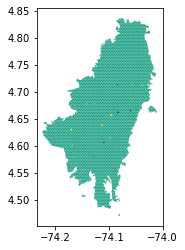

In [83]:
acessibility_data = pd.merge(bogota_hex_access_no_gondola, bogota_hex_access_gondola, on=['HEXID','geometry'], suffixes = ('_ng','_g'))
for time in cutoff_times :
    data_g = str(time) +'_g'
    data_ng = str(time) + '_ng'
    acessibility_data[str(time) + '_c'] = acessibility_data[data_g] - acessibility_data[data_ng]
    acessibility_data[str(time) + '_cp'] = 100*(acessibility_data[data_g] - acessibility_data[data_ng])/acessibility_data[data_ng]
    acessibility_data.fillna(0,inplace=True)

acessibility_data.to_file(run_path + 'accessibility_data'+'.geojson', driver="GeoJSON")

acessibility_data.plot(column='30_c')
# acessibility_data_60_clean = acessibility_data.drop(index=[243,15,4052], axis=0)


## Data Visualization <a class="anchor" id="data_vis"></a>

We chose a few key visualizations to reveal how employment and acessibility varied across the city, as well as how it changed with the advent of the gondola.  The key plots are outlined below:

1. Employment Plot 

2. Bogota Accessibility Total Plot (no gondola case)

3. Bogota Acessibility Change Plot

4. Ciudad Bolivar Acessiblity Change Plot


### 1. Employment Plot 

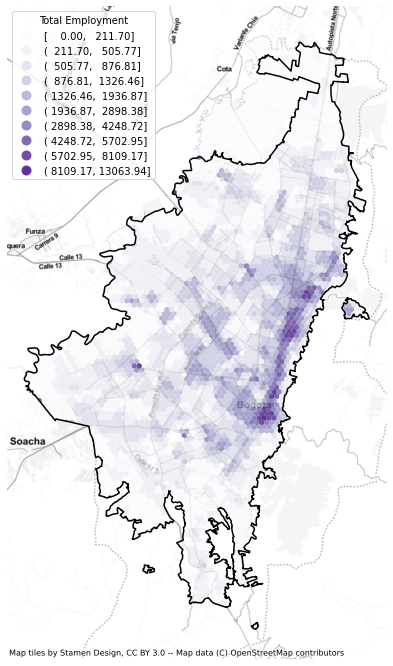

In [84]:
# 1 EMPLOYMENT PLOT 

# When using double square root, notice how it becomes clear how jobs are concentrated at some points and not others
bogota_hex_jobs_projected = bogota_hex_jobs
bogota_hex_jobs_projected['sqrt_jobs'] = np.sqrt(np.sqrt(bogota_hex_jobs_projected['jobs_count']))
bogota_hex_jobs_projected.crs = {'init':'epsg:4326'}
bogota_hex_jobs_projected = bogota_hex_jobs_projected.to_crs(epsg=3857)

# Figure Setup 
fig, ax = plt.subplots(1,1, figsize=(12,12))
#plt.title('Employment Distribution')
plt.axis('off')

# Bogota Boundary
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
bogota_boundary = bogota_boundary.to_crs(epsg=3857)
bogota_boundary.boundary.plot(ax = ax, color='k')

# Plot Employment
bogota_hex_jobs_projected.plot(ax = ax, column = 'jobs_count', legend=True, legend_kwds={"loc":'upper left',"title":"Total Employment"}, cmap='Purples', alpha=0.8, scheme='naturalbreaks', k=10)

# Ciudad Bolivar Hatched
# neighborhood_boundaries = gpd.read_file(city_data + 'bogota_neighborhood_boundaries.shp')
# ciudad_bolivar_full_boundary = neighborhood_boundaries[neighborhood_boundaries['LocNombre'] == 'CIUDAD BOLIVAR']
# ciudad_bolivar_full_boundary = ciudad_bolivar_full_boundary.to_crs(epsg=3857)
# ciudad_bolivar_boundary = gpd.overlay(ciudad_bolivar_full_boundary, bogota_boundary, how='intersection')
# ciudad_bolivar_boundary.plot(ax=ax, hatch="//", color='w', alpha=0)
# ciudad_bolivar_boundary.boundary.plot(ax=ax, color='k')

# Add Basemap
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

plt.savefig(run_path + 'plot1_employment.png', dpi=400)


### 2. Bogota Acessibility Total Plot (no gondola data)

In [49]:
out = 

(10, 30]     1380
(30, 50]     1099
(0, 10]       814
(50, 70]      787
(70, 90]      451
(90, 100]       0
Name: 60_percent, dtype: int64

<AxesSubplot:>

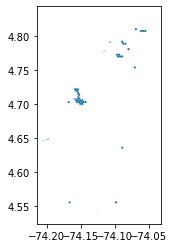

In [45]:
bogota_hex_access_gondola[bogota_hex_access_gondola[60] == 0].plot()

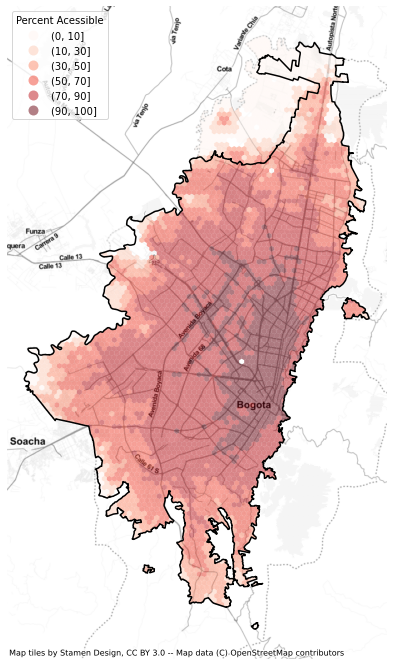

In [85]:
# 2. BOGOTA ACESSIBILITY PLOT

bogota_hex_access_no_gondola_projected = bogota_hex_access_no_gondola
bogota_hex_access_no_gondola_projected.crs = {'init':'epsg:4326'}
bogota_hex_access_no_gondola_projected = bogota_hex_access_no_gondola_projected.to_crs(epsg=3857)

# Plot Axes
fig, ax = plt.subplots(1,1, figsize=(12,12))

# Bogota Boundary
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
bogota_boundary = bogota_boundary.to_crs(epsg=3857)
bogota_boundary.boundary.plot(ax = ax, color='k')

# Hexagons
bogota_hex_access_no_gondola_projected['60_percent'] = 100*bogota_hex_access_no_gondola_projected[60]/sum(bogota_hex_jobs['jobs_count'])
bogota_hex_access_no_gondola_projected['percent_binned'] = pd.cut(bogota_hex_access_no_gondola_projected['60_percent'], bins=[0,10,30,50,70,90,100])
bogota_hex_access_no_gondola_projected.plot(ax = ax, column = 'percent_binned', legend=True, legend_kwds={"loc":'upper left',"title":"Percent Acessible"}, cmap='Reds', alpha=0.5)
# plt.title('60 Minute Employment Acessibility in Bogota')
plt.axis('off')

# Gondola
# plt.scatter(points_origins['X'], points_origins['Y'], marker='o', s=10)
# plt.title('Acessibility in Ciudad Bolivar')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

# Ciudad Bolivar Label
# ciudad_bolivar_y, ciudad_bolivar_x = 4.546088, -74.153357
# plt.text(ciudad_bolivar_x, ciudad_bolivar_y, 'Ciudad Bolivar', fontsize=10)
# plt.scatter(ciudad_bolivar_x, ciudad_bolivar_y, marker='*', s = 50)

# Ciudad Bolivar Hatched
# neighborhood_boundaries = gpd.read_file(city_data + 'bogota_neighborhood_boundaries.shp')
# ciudad_bolivar_full_boundary = neighborhood_boundaries[neighborhood_boundaries['LocNombre'] == 'CIUDAD BOLIVAR']
# ciudad_bolivar_full_boundary = ciudad_bolivar_full_boundary.to_crs(epsg=3857)
# ciudad_bolivar_boundary = gpd.overlay(ciudad_bolivar_full_boundary, bogota_boundary, how='intersection')
# ciudad_bolivar_boundary.plot(ax=ax, hatch="//", color='w', alpha=0)
# ciudad_bolivar_boundary.boundary.plot(ax=ax, color='k')

# Add Basemap
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

plt.savefig(run_path + 'plot2_bogota_acesss_total.png', dpi=400)



### 3. Bogota Acessibility Change

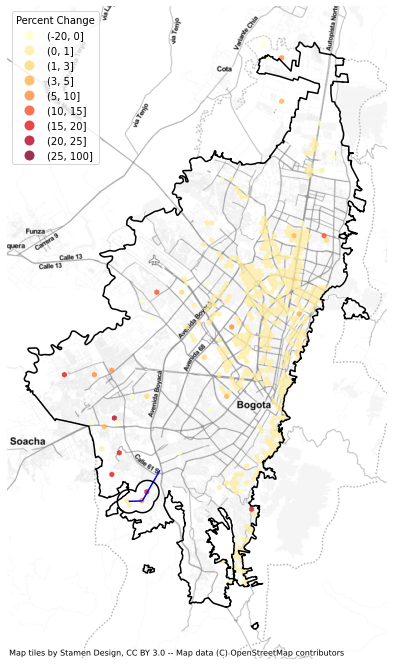

In [86]:
# 3. WHOLE CITY CHANGE PLOT 

# Calculate absolute and percent change
bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
cols = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).columns
for col in cols :
    # ABSOLUTE TOGGLE
    # bogota_hex_access_change[col] = bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col]
    # PERCENT TOGGLE
    bogota_hex_access_change[col] = 100*(bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col])/bogota_hex_access_no_gondola[col]

    
# Drop all zero valued hexagons  
bogota_hex_access_change = bogota_hex_access_change[bogota_hex_access_change[60] != 0]

# Drop outlier hexagons
#bogota_hex_access_change = bogota_hex_access_change.drop(index=[243,15,4052], axis=0)

# Drop all hexagons outside ciudad bolivar
# xmin,ymin,xmax,ymax = -74.172710, 4.540929, -74.133142, 4.574040
# bogota_hex_access_change = bogota_hex_access_change.cx[xmin:xmax, ymin:ymax]

# Change projection type
bogota_hex_access_change.crs = {'init':'epsg:4326'}
bogota_hex_access_change = bogota_hex_access_change.to_crs(epsg=3857)

# Plot Axes
fig, ax = plt.subplots(1,1, figsize=(12,12))

# Bogota Boundary
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
bogota_boundary = bogota_boundary.to_crs(epsg=3857)
bogota_boundary.boundary.plot(ax = ax, color='k')

# Hexagons
#bogota_hex_access_change.plot(ax = ax, column = 60, legend=True, legend_kwds={"loc":'upper left',"title":"Percent Change"}, cmap='YlOrRd', alpha=0.8, scheme='naturalbreaks', k=9)      
bogota_hex_access_change['percent_change_bins'] = pd.cut(bogota_hex_access_change[60], bins=[-20,0,1,3,5,10,15,20,25,100])
bogota_hex_access_change.plot(ax = ax, column = 'percent_change_bins', legend=True, legend_kwds={"loc":'upper left',"title":"Percent Change"}, cmap='YlOrRd', alpha=0.8)      
# plt.title('Percent Change in 60 minute Acessibility in Ciudad Bolivar')
plt.axis('off')

# Zoom into Ciudad Bolivar
# xmin, xmax, ymin, ymax = -8256500, -8252500, 506100, 509500
# ax.set_xlim(xmin,xmax)
# ax.set_ylim(ymin,ymax)

# Gondola new 
# gondola_stations = pd.read_csv('points_origins.csv')
# gondola_stations = gpd.GeoDataFrame(gondola_stations, geometry=gpd.points_from_xy(gondola_stations['X'], gondola_stations['Y']))
# gondola_stations.crs = {'init':'epsg:4326'}
# gondola_stations = gondola_stations.to_crs(epsg=3857)
# gondola_stations.plot(ax=ax, color='r')

# Gondola Names
# for x, y, label in zip(gondola_stations.geometry.x, gondola_stations.geometry.y, gondola_stations['Description']):
#     ax.annotate(label, xy=(x, y), xytext=(0, -15), textcoords="offset points")

# Gondola from SHP file 
gondola_estaciones = gpd.read_file(city_data + 'Estaciones.shp')
gondola_estaciones.crs = {'init':'epsg:4326'}
gondola_estaciones = gondola_estaciones.to_crs(epsg=3857)
gondola_estaciones.plot(ax=ax, color='b')

gondola_line = gpd.read_file(city_data + 'tmc_line.shp')
gondola_line.crs = {'init':'epsg:4326'}
gondola_line = gondola_line.to_crs(epsg=3857)
gondola_line.plot(ax=ax, color='b')
    
# Plot 800 meter buffer around site 
gondola_area = gpd.read_file(city_data + 'cablesarea.geojson')
gondola_area = gondola_area[gondola_area['station_area'] == 'cb']
# gondola_area.crs = {'init':'epsg:4326'}
gondola_area = gondola_area.to_crs(epsg=3857)
gondola_area.boundary.plot(ax=ax, color='k')
    

# OLD Gondola
# plt.scatter(points_origins['X'], points_origins['Y'], marker='o', s=10)
# plt.title('Acessibility in Ciudad Bolivar')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')


# Add Basemap
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

plt.savefig(run_path + 'plot3_bogota_access_change.png', dpi=400)



In [59]:
bogota_hex_access_change.iloc[0]

HEXID                                                       0
geometry    POLYGON ((-8246603.555248507 538942.8668396149...
0                                                         NaN
10                                                    111.454
15                                                     22.976
20                                                    43.2943
30                                                    20.8855
40                                                    43.1007
45                                                    38.3099
50                                                    65.5052
60                                                    36.3927
70                                                    57.1748
75                                                    326.409
80                                                    358.404
90                                                      177.7
100                                                   149.381
115     

In [63]:
bogota_hex_access_gondola

,HEXID,geometry,0,10,15,20,30,40,45,50,60,70,75,80,90,100,115,110,120
0,0,"POLYGON ((-74.08050 4.83566, -74.08134 4.83517...",0.0,367.837100,539.347587,776.358582,938.504935,1343.006866,1611.590257,2222.746246,3031.664153,4765.012112,14100.944487,21678.389558,60088.048890,148789.098899,455318.603644,322739.206738,6.215615e+05
1,1,"POLYGON ((-74.07670 4.83682, -74.07670 4.83606...",0.0,367.837100,539.347587,776.358582,938.504935,1343.006866,1611.590257,2222.746246,3031.664153,4765.012112,14100.944487,21678.389558,60088.048890,148789.098899,455318.603644,322739.206738,6.215615e+05
2,2,"POLYGON ((-74.07361 4.83631, -74.07361 4.83606...",0.0,367.837100,539.347587,776.358582,938.504935,1343.006866,1611.590257,2222.746246,3031.664153,4765.012112,14100.944487,21678.389558,60088.048890,148789.098899,455318.603644,322739.206738,6.215615e+05
3,3,"POLYGON ((-74.07274 4.83556, -74.07361 4.83606...",0.0,367.837100,539.347587,776.358582,938.504935,1343.006866,1611.590257,2222.746246,3031.664153,4765.012112,14100.944487,21678.389558,60088.048890,148789.098899,455318.603644,322739.206738,6.215615e+05
4,4,"POLYGON ((-74.06539 4.83546, -74.06588 4.83517...",0.0,158.296294,208.465649,299.336028,1144.812695,1173.482648,1392.340460,1637.927176,2902.229722,11003.249595,14576.621123,22645.111463,66905.298711,161627.857489,496516.525150,350701.350743,6.614638e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,4579,"POLYGON ((-74.07927 4.47412, -74.07979 4.47382...",0.0,328.876207,328.876207,328.876207,328.876207,328.876207,328.876207,934.920490,7463.200274,21672.255938,32983.705910,48453.182243,108000.097530,226725.086353,616883.106934,493779.669997,8.079031e+05
4580,4580,"POLYGON ((-74.08288 4.47310, -74.08288 4.47265...",0.0,328.876207,328.876207,328.876207,328.876207,711.891894,2625.109238,5902.465256,18002.530343,41403.047981,62745.545854,93921.596660,189862.811985,443146.949791,928684.321594,752162.351168,1.079302e+06
4581,4581,"POLYGON ((-74.08065 4.47431, -74.07979 4.47382...",0.0,328.876207,328.876207,328.876207,328.876207,328.876207,711.891894,3009.573871,10971.540125,30572.364883,45955.567912,69092.225854,138742.376979,322120.615329,768014.941765,585174.757851,9.527620e+05
4582,4582,"POLYGON ((-74.07958 4.47191, -74.07979 4.47203...",0.0,328.876207,328.876207,328.876207,328.876207,328.876207,328.876207,1159.559804,8112.942795,23428.907722,34558.494030,52813.119684,111891.493311,236654.081159,634247.919112,513024.627596,8.349272e+05


In [62]:
bogota_hex_access_no_gondola

,HEXID,geometry,0,10,15,20,30,40,45,50,60,70,75,80,90,100,115,110,120
0,0,"POLYGON ((-74.08050 4.83566, -74.08134 4.83517...",0.0,173.955924,438.579536,541.793024,776.358582,938.504935,1165.202409,1343.006866,2222.746246,3031.664153,3306.909523,4729.104715,21637.779797,59663.396465,225545.195436,147858.242874,3.217931e+05
1,1,"POLYGON ((-74.07670 4.83682, -74.07670 4.83606...",0.0,173.955924,438.579536,541.793024,776.358582,938.504935,1165.202409,1343.006866,2222.746246,3031.664153,3306.909523,4729.104715,21637.779797,59663.396465,225545.195436,147858.242874,3.217931e+05
2,2,"POLYGON ((-74.07361 4.83631, -74.07361 4.83606...",0.0,317.667745,539.347587,541.793024,925.582753,1165.202409,1343.006866,1611.590257,2533.699531,3306.909523,4729.104715,13930.649595,31147.364971,92649.304419,321106.315212,225161.414298,4.537957e+05
3,3,"POLYGON ((-74.07274 4.83556, -74.07361 4.83606...",0.0,367.837100,539.347587,776.358582,938.504935,1343.006866,1611.590257,2222.746246,3031.664153,4765.012112,14100.944487,21678.389558,60088.048890,148789.098899,455318.603644,322739.206738,6.215615e+05
4,4,"POLYGON ((-74.06539 4.83546, -74.06588 4.83517...",0.0,158.296294,208.465649,299.336028,1144.812695,1173.482648,1392.340460,1637.927176,2902.229722,11003.249595,14576.621123,22645.111463,66905.298711,161627.857489,496516.525150,350701.350743,6.614638e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,4579,"POLYGON ((-74.07927 4.47412, -74.07979 4.47382...",0.0,328.876207,328.876207,328.876207,328.876207,328.876207,328.876207,934.920490,7463.200274,21672.255938,32983.705910,48453.182243,108000.097530,226725.086353,616883.106934,493779.669997,8.079031e+05
4580,4580,"POLYGON ((-74.08288 4.47310, -74.08288 4.47265...",0.0,328.876207,328.876207,328.876207,328.876207,711.891894,2625.109238,5902.465256,18002.530343,41403.047981,62745.545854,93921.596660,189862.811985,443146.949791,928684.321594,752162.351168,1.079302e+06
4581,4581,"POLYGON ((-74.08065 4.47431, -74.07979 4.47382...",0.0,328.876207,328.876207,328.876207,328.876207,328.876207,711.891894,3009.573871,10971.540125,30572.364883,45955.567912,69092.225854,138742.376979,322120.615329,768014.941765,585174.757851,9.527620e+05
4582,4582,"POLYGON ((-74.07958 4.47191, -74.07979 4.47203...",0.0,328.876207,328.876207,328.876207,328.876207,328.876207,328.876207,1159.559804,8112.942795,23428.907722,34558.494030,52813.119684,111891.493311,236654.081159,634247.919112,513024.627596,8.349272e+05


### 4. Ciudad Bolivar Acessibility Change

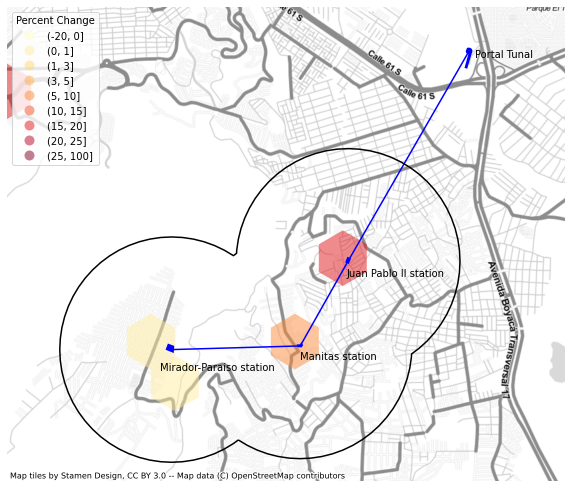

In [87]:
# CIUDAD BOLIVAR PLOT 

# Calculate absolute and percent change
bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
cols = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).columns
for col in cols :
    # ABSOLUTE TOGGLE
    # bogota_hex_access_change[col] = bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col]
    # PERCENT TOGGLE
    bogota_hex_access_change[col] = 100*(bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col])/bogota_hex_access_no_gondola[col]

    
# Drop all zero valued hexagons  
bogota_hex_access_change = bogota_hex_access_change[bogota_hex_access_change[60] != 0]

# Drop outlier hexagons
# bogota_hex_access_change = bogota_hex_access_change.drop(index=[243,15,4052], axis=0)

# Drop all hexagons outside ciudad bolivar
# xmin,ymin,xmax,ymax = -74.172710, 4.540929, -74.133142, 4.574040
# bogota_hex_access_change = bogota_hex_access_change.cx[xmin:xmax, ymin:ymax]

# Change projection type
bogota_hex_access_change.crs = {'init':'epsg:4326'}
bogota_hex_access_change = bogota_hex_access_change.to_crs(epsg=3857)


# Plot Axes
fig, ax = plt.subplots(1,1, figsize=(10,10))

# Bogota Boundary
# place = {'city': 'Bogota',
#          'country':'Colombia'}
# bogota_boundary = ox.gdf_from_place(place)
# bogota_boundary.crs = {'init':'epsg:4326'}
# bogota_boundary = bogota_boundary.to_crs(epsg=3857)
# bogota_boundary.boundary.plot(ax = ax, color='k')

# Hexagons
bogota_hex_access_change['percent_change_bins'] = pd.cut(bogota_hex_access_change[60], bins=[-20,0,1,3,5,10,15,20,25,100])
bogota_hex_access_change.plot(ax = ax, column = 'percent_change_bins', legend=True, legend_kwds={"loc":'upper left','title':'Percent Change'}, cmap='YlOrRd', alpha=0.5)
# plt.title('Percent Change in 60 minute Acessibility in Ciudad Bolivar')
plt.axis('off')

# Zoom into Ciudad Bolivar
xmin, xmax, ymin, ymax = -8256500, -8252500, 506100, 509500
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

# Gondola Names
gondola_stations = pd.read_csv(city_data + 'gondola_stations.csv')
gondola_stations = gpd.GeoDataFrame(gondola_stations, geometry=gpd.points_from_xy(gondola_stations['X'], gondola_stations['Y']))
gondola_stations.crs = {'init':'epsg:4326'}
gondola_stations = gondola_stations.to_crs(epsg=3857)
for x, y, label in zip(gondola_stations.geometry.x, gondola_stations.geometry.y, gondola_stations['Description']):
    ax.annotate(label, xy=(x, y), xytext=(0, -15), textcoords="offset points")
# gondola_stations.plot(ax=ax, color='r')
    
# Gondola from SHP file 
gondola_estaciones = gpd.read_file(city_data + 'Estaciones.shp')
gondola_estaciones.crs = {'init':'epsg:4326'}
gondola_estaciones = gondola_estaciones.to_crs(epsg=3857)
gondola_estaciones.plot(ax=ax, color='b')

gondola_line = gpd.read_file(city_data + 'tmc_line.shp')
gondola_line.crs = {'init':'epsg:4326'}
gondola_line = gondola_line.to_crs(epsg=3857)
gondola_line.plot(ax=ax, color='b')
    
# Plot 800 meter buffer around site 
gondola_area = gpd.read_file(city_data + 'cablesarea.geojson')
gondola_area = gondola_area[gondola_area['station_area'] == 'cb']
# gondola_area.crs = {'init':'epsg:4326'}
gondola_area = gondola_area.to_crs(epsg=3857)
gondola_area.boundary.plot(ax=ax, color='k')
    

# OLD Gondola
# plt.scatter(points_origins['X'], points_origins['Y'], marker='o', s=10)
# plt.title('Acessibility in Ciudad Bolivar')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')


# Add Basemap
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

plt.savefig(run_path + 'plot4_ciudad_bolivar_access_change.png', dpi=400)



## Conclusion <a class="anchor" id="conclusion"></a>

Remarks on the plots and data analysis across different hexagon sizes can be found in our paper.

In [ ]:
# Plot accessibility at 60 minute mark

times = [10, 30, 50, 70, 90, 110]

fix, axs = plt.subplots(3,2, figsize = (20,30))

for i in range(len(times)) :
    row_spot = math.floor(i/2)
    col_spot = i%2
    bogota_hex_access_no_gondola.plot(ax=axs[row_spot,col_spot], column = times[i], legend=True)
    title = 'Pre-Gondola Acessibility at ' + str(times[i]) + 'min'
    axs[row_spot,col_spot].set_title(title)



In [ ]:
# Plot Change in Accessibility before/after gondola 
# display(bogota_hex_access_no_gondola)
# display(bogota_hex_access_gondola)

bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]

cols = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).columns

for col in cols :
    bogota_hex_access_change[col] = bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col]
    
times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

fix, axs = plt.subplots(math.floor(i/2),2, figsize = (20,30))

for i in range(len(times)) :
    row_spot = math.floor(i/2)
    col_spot = i%2
    bogota_hex_access_change.plot(ax=axs[row_spot,col_spot], column = times[i], legend=True)
    title = 'Change in acessibiilty at ' + str(times[i]) + 'min'
    axs[row_spot,col_spot].set_title(title)
    # Ciudad bolivar Boundaries
    xmin,ymin,xmax,ymax = -74.172710, 4.540929, -74.133142, 4.574040
    axs[row_spot,col_spot].set_xlim(xmin,xmax)
    axs[row_spot,col_spot].set_ylim(ymin,ymax)
    
    

In [ ]:
# Plot the graphs for a given points accessability 
# Inputs: 
    # Hexagons with accessitiblities
    # File with points desired to have accessibility calculated at

points = pd.read_csv('points_destinations.csv')

geo_points = gpd.GeoDataFrame(points, geometry=geopandas.points_from_xy(points['X'], points['Y']))

from shapely.ops import nearest_points

points_with_hexid = gpd.sjoin(geo_points, bogota_hex, how='left', op='within')


# hex_points = nearest_points(geo_points.unary_union, bogota_hex_centroid.unary_union)
# print(hex_points)

to_plot = points_with_hexid

columns = 3
rows = math.floor((len(to_plot)/columns))+1
fig, axs = plt.subplots(rows, columns, figsize=(12, 6*rows))
#fig.suptitle('Acessibility at various points (Orange:Gondola, Blue: No Gondola)')

for i in range(len(to_plot)) :  
    no_gon_vals = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    axs[math.floor(i/columns), i%columns].plot(no_gon_vals.index, no_gon_vals.values, marker='s', label = 'no gondola')

    gon_vals = bogota_hex_access_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    axs[math.floor(i/columns), i%columns].plot(gon_vals.index, gon_vals.values, label = 'gondola')
    
    axs[math.floor(i/columns), i%columns].set_title(to_plot['Description'][i])
    axs[math.floor(i/columns), i%columns].set_ylabel('Jobs Accessible')
    axs[math.floor(i/columns), i%columns].set_xlabel('Max Travel Time [min]')




In [ ]:
to_plot = points_with_hexid

fig, ax = plt.subplots(figsize=(15,15))
ax.set_ylabel('Jobs Accessible')
ax.set_xlabel('Max Travel Time [min]')
ax.set_title('No Gondola Baseline Accessibility')

to_plot = points_with_hexid.iloc[0:10]

for i in range(len(to_plot)):
    no_gon_vals = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    ax.plot(no_gon_vals.index, no_gon_vals.values, marker='s', label = to_plot['Description'][i])

ax.legend()



# +===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+===+

# Scratchwork



In [ ]:
# Plot Ciudad bolivar specific Area 
# Plot hexagons showing change (with white/transparent being zero)
# Plot gondola stations, ideally with labels 
# Plot background terrain for context of hexagons 

bogota_hex_access_change = bogota_hex_access_no_gondola[['HEXID','geometry']]
bogota_hex_access_change_percent = bogota_hex_access_no_gondola[['HEXID','geometry']]


cols = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).columns

for col in cols :
    bogota_hex_access_change[col] = bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col]
    bogota_hex_access_change_percent[col] = 100*(bogota_hex_access_gondola[col] - bogota_hex_access_no_gondola[col])/bogota_hex_access_no_gondola[col]

# Drop all zero valued hexagons to reflect 
bogota_hex_access_change = bogota_hex_access_change[bogota_hex_access_change[60] != 0]

# Ciudad bolivar Boundaries
xmin,ymin,xmax,ymax = -74.172710, 4.540929, -74.133142, 4.574040
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
bogota_hex_access_change = bogota_hex_access_change.cx[xmin:xmax, ymin:ymax]


fig, ax = plt.subplots(1,1, figsize = (10,10))

# Bogota Boundary
place = {'city': 'Bogota',
         'country':'Colombia'}
bogota_boundary = ox.gdf_from_place(place)
bogota_boundary.crs = {'init':'epsg:4326'}
#bogota_boundary = bogota_boundary.to_crs(epsg=3857)
bogota_boundary.boundary.plot(ax = ax, color='k')

# Street Network
# fig, ax = ox.plot_graph(ax=ax, G)

# Hexagons
# bogota_hex_access_change vs. bogota_hex_access_change_percent , can toggle
bogota_hex_access_change_percent.plot(ax=ax, column = 60, legend=True, cmap="Wistia")

ax.plot(points_origins['X'],points_origins['Y'])
# Gondola
for i in range(len(points_origins)) : 
    plt.text(points_origins['X'][i], points_origins['Y'][i]-.0015, points_origins['Description'][i], fontsize= 10)
plt.scatter(points_origins['X'], points_origins['Y'], marker='o', s=100)

plt.title('Acessibility Change in Ciudad Bolivar')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add basemap
#ctx.add_basemap(ax)



In [ ]:
# Find geometries with most and least changed travel times!
geo_travel_times_all[geo_travel_times_all['travel_time_min_gondola'] != geo_travel_times_all['travel_time_min_no_gondola']]['origin'].value_counts()

In [ ]:
fig, axs = plt.subplots(rows, columns, figsize=(12, 6*rows))
#fig.suptitle('Acessibility at various points (Orange:Gondola, Blue: No Gondola)')

for i in range(len(to_plot)) :  
    no_gon_vals = bogota_hex_access_no_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    axs[math.floor(i/columns), i%columns].plot(no_gon_vals.index, no_gon_vals.values, marker='s', label = 'no gondola')

    gon_vals = bogota_hex_access_gondola.drop(columns=['HEXID','geometry']).loc[to_plot['HEXID'][i]]
    axs[math.floor(i/columns), i%columns].plot(gon_vals.index, gon_vals.values, label = 'gondola')
    
    axs[math.floor(i/columns), i%columns].set_title(to_plot['Description'][i])
    axs[math.floor(i/columns), i%columns].set_ylabel('Jobs Accessible')
    axs[math.floor(i/columns), i%columns].set_xlabel('Max Travel Time [min]')

### SCRATCHWORK

Website on how to concatenate csv files:

https://stackoverflow.com/questions/44791212/concatenating-multiple-csv-files-into-a-single-csv-with-the-same-header-python#44791486
    